# Загрузка данных и предобработка

In [1]:
import pandas as pd
import psycopg2
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import seaborn as sns 
import statsmodels.stats.proportion as proportion
from scipy.stats import ttest_ind,mannwhitneyu,shapiro,norm
from statsmodels.stats.weightstats import ztest
from tqdm import tqdm
import timeit
from scipy import stats
from sqlalchemy import create_engine
import math
import datetime
from datetime import date, datetime, timedelta
import time
from sqlalchemy import create_engine, text
from sqlalchemy.orm import sessionmaker

import warnings
warnings.filterwarnings("ignore")

def get_engine(db_name):
    if db_name == 'antares':
        user=''
        password=''
        host='10.250.201.21'
        engine = create_engine(f'postgresql://{user}:{password}@{host}:5432/{db_name}')
    elif db_name == 'dwh':
        user=''
        password=''
        host='10.250.201.241'
        dbname='dwh'
        engine = create_engine(f'postgresql://{user}:{password}@{host}:5432/{db_name}')
    return engine
        



def execute(SQL, db_name = 'dwh'):
    start_time = time.time()  # запоминаем время начала выполнения функции
    engine = get_engine(db_name)
    Session = sessionmaker(bind=engine)  # sessions factory ()
    with Session() as session: # open session
        result = session.execute(text(SQL))
        df = pd.DataFrame(result.fetchall(), columns=result.keys())
        
    end_time = time.time()  # запоминаем время окончания выполнения функции
    execution_time = end_time - start_time  # вычисляем время выполнения   
    
    print(f"Время выполнения функции: {execution_time} секунд")
    return df
    

In [2]:
query = ''' SELECT * FROM sandbox.mekhtiev_ab_users'''

df = execute(query,db_name='dwh')
df['date_msk']=df['date_msk'].astype('datetime64[ns]')   
df['watchtime']=df['watchtime'].astype('float')
df['broadcast']=df['broadcast'].astype('int')
df.info()

Время выполнения функции: 7.929105758666992 секунд
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1066536 entries, 0 to 1066535
Data columns (total 14 columns):
 #   Column               Non-Null Count    Dtype         
---  ------               --------------    -----         
 0   date_msk             1066536 non-null  datetime64[ns]
 1   device_id            1066536 non-null  object        
 2   empty_user           845763 non-null   float64       
 3   profile_type         1066536 non-null  object        
 4   bot_flag             1066536 non-null  int64         
 5   os_name              1066536 non-null  int64         
 6   os_version           1034476 non-null  object        
 7   app_version_name     1034476 non-null  object        
 8   device_manufacturer  1034476 non-null  object        
 9   device_model         1034476 non-null  object        
 10  country_type         1034476 non-null  object        
 11  experiment_group     845763 non-null   object        
 12  watch

In [3]:
df['date_msk'].unique()

<DatetimeArray>
['2024-02-11 00:00:00', '2024-02-14 00:00:00', '2024-02-09 00:00:00',
 '2024-02-16 00:00:00', '2024-02-20 00:00:00', '2024-02-12 00:00:00',
 '2024-02-18 00:00:00', '2024-02-19 00:00:00', '2024-02-15 00:00:00',
 '2024-02-17 00:00:00', '2024-02-10 00:00:00', '2024-02-21 00:00:00',
 '2024-02-13 00:00:00']
Length: 13, dtype: datetime64[ns]

In [4]:
start_date = datetime.strptime("2024-02-16", "%Y-%m-%d")
end_date = datetime.strptime("2024-02-21", "%Y-%m-%d")

In [5]:
query_retention =f"""
            SELECT 
                device_id,  
                first_date_in_app,
                client,
                count(CASE WHEN retention_day=0 THEN device_id END) AS d_0,
                count(CASE WHEN retention_day=1 THEN device_id END) AS d_1,
                count(CASE WHEN retention_day=3 THEN device_id END) AS d_3
                FROM(
                    SELECT
                    t2.event_date_msk as first_date_in_app, --дата нулевого дня
                    t1.date_msk, 
                    t1.client,
                    t1.date_msk-t2.event_date_msk as retention_day,  -- число дней, когда пользователь вернулся
                    t1.device_id
                    FROM (SELECT date_msk,lower(device_id::TEXT) AS device_id,client,sum(cnt_video) AS cnt_video FROM dds.fct_dds_backend_streams_watchtime_by_user
                          WHERE date_msk BETWEEN '{start_date}' AND '{end_date}' AND reference=1
                          GROUP BY 1,2,3
                          ) AS t1
                    INNER JOIN (SELECT event_date_msk,lower(yappy_device_uuid::TEXT) AS yappy_device_uuid FROM dds.fct_dds_appm_first_event_device_uuid_app_open
                                WHERE event_date_msk BETWEEN '{start_date}' AND '{end_date}'
                                )AS t2
                    ON t1.device_id=t2.yappy_device_uuid
                    )t1
                GROUP BY 1,2,3
                """


df_retention = execute(query_retention,db_name='dwh')
df_retention['first_date_in_app'] = df_retention['first_date_in_app'].astype('datetime64[ns]')
df_retention.info()

Время выполнения функции: 1.3986659049987793 секунд
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 190764 entries, 0 to 190763
Data columns (total 6 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   device_id          190764 non-null  object        
 1   first_date_in_app  190764 non-null  datetime64[ns]
 2   client             190764 non-null  int64         
 3   d_0                190764 non-null  int64         
 4   d_1                190764 non-null  int64         
 5   d_3                190764 non-null  int64         
dtypes: datetime64[ns](1), int64(4), object(1)
memory usage: 8.7+ MB


In [6]:
df_retention.groupby('first_date_in_app')['d_0'].sum()

first_date_in_app
2024-02-16    30968
2024-02-17    32934
2024-02-18    31993
2024-02-19    30281
2024-02-20    31227
2024-02-21    30947
Name: d_0, dtype: int64

In [7]:
df_merge = pd.merge(df,df_retention,on='device_id',how='left')
df_merge.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1066536 entries, 0 to 1066535
Data columns (total 19 columns):
 #   Column               Non-Null Count    Dtype         
---  ------               --------------    -----         
 0   date_msk             1066536 non-null  datetime64[ns]
 1   device_id            1066536 non-null  object        
 2   empty_user           845763 non-null   float64       
 3   profile_type         1066536 non-null  object        
 4   bot_flag             1066536 non-null  int64         
 5   os_name              1066536 non-null  int64         
 6   os_version           1034476 non-null  object        
 7   app_version_name     1034476 non-null  object        
 8   device_manufacturer  1034476 non-null  object        
 9   device_model         1034476 non-null  object        
 10  country_type         1034476 non-null  object        
 11  experiment_group     845763 non-null   object        
 12  watchtime            1063627 non-null  float64       
 1

In [8]:
df_merge.groupby('first_date_in_app')['d_0'].sum()

first_date_in_app
2024-02-16    54429.0
2024-02-17    54505.0
2024-02-18    49430.0
2024-02-19    43228.0
2024-02-20    40870.0
2024-02-21    33640.0
Name: d_0, dtype: float64

In [9]:
df_merge.groupby(['date_msk','experiment_group'])['device_id'].nunique()

date_msk    experiment_group      
2024-02-09  lenta_weight_control_B    16347
            lenta_weight_test_A       16488
2024-02-10  lenta_weight_control_B    18057
            lenta_weight_test_A       18025
2024-02-11  lenta_weight_control_B    19850
            lenta_weight_test_A       19956
2024-02-12  lenta_weight_control_B    22361
            lenta_weight_test_A       22501
2024-02-13  lenta_weight_control_B    25112
            lenta_weight_test_A       24834
2024-02-14  lenta_weight_control_B    37997
            lenta_weight_test_A       38095
2024-02-15  lenta_weight_control_B    35808
            lenta_weight_test_A       36122
2024-02-16  lenta_weight_control_B    38108
            lenta_weight_test_A       38012
2024-02-17  lenta_weight_control_B    39803
            lenta_weight_test_A       40026
2024-02-18  lenta_weight_control_B    40241
            lenta_weight_test_A       40393
2024-02-19  lenta_weight_control_B    41415
            lenta_weight_test_A       413

In [12]:
df_merge['first_date_in_app'].fillna('2000-01-01',inplace=True) ## Вместо null вбил рандомную старую дату
df_merge['d_0'].fillna(0,inplace=True)
df_merge['d_1'].fillna(0,inplace=True)
df_merge['d_3'].fillna(0,inplace=True)

In [13]:
df_merge[df_merge['first_date_in_app']!='2000-01-01'].groupby('date_msk')['device_id'].nunique().reset_index()

,date_msk,device_id
0,2024-02-09,7
1,2024-02-10,10
2,2024-02-11,9
3,2024-02-12,13
4,2024-02-13,25
5,2024-02-14,24
6,2024-02-15,52
7,2024-02-16,31044
8,2024-02-17,39122
9,2024-02-18,43071


# Рассмотрим отдельно сабленты

In [ ]:
import psycopg2
connection_2 =psycopg2.connect(
                             database="svr_prod",
                             host="10.250.201.21",
                             password="",
                             port="5432",
                             user="",
                             ) 

In [ ]:
with connection_2.cursor() as cursor:
        query ='''  SELECT 
                    event_created_at::date AS date_msk,
                    device_id,
                    video_uuid,
                    sublenta,
                    CASE WHEN profile_uuid IS NULL THEN 'Незарег' ELSE 'Зарег' END profile_type                
                    FROM svr_streams ss 
                    WHERE reference=1 AND event_created_at::date BETWEEN '2024-02-03' and '2024-02-09' AND sublenta='start_select'
                    GROUP BY 1,2,3,4,5
                    '''
        print("Время выполнения запроса:",timeit.timeit(lambda: cursor.execute(query), number=1),"секунд")
        #cursor.execute(query)
        df_svr=cursor.fetchall() 
cursor.close()        

In [ ]:
columns=[]
for i in cursor.description:
    columns.append(i[0])
df_svr=pd.DataFrame(df_svr,columns=columns)      
df_svr['date_msk'] = df_svr['date_msk'].astype('datetime64[ns]')

In [ ]:
unique_videos = df_svr.drop_duplicates('video_uuid')[['video_uuid']]
unique_videos

In [ ]:
import psycopg2
connection =psycopg2.connect(
                             database="dwh",
                             host="10.250.201.241",
                             password="fsOwuFsj1XIU",
                             port="5432",
                             user="k.mekhtiev",
                             ) 

with connection.cursor() as cursor:    
        query =''' SELECT 
                    event_created_at_msk::date AS date_msk,
                    lower(device_id) AS device_id,
                    object_uuid,
                    client,
                    DEPTH AS watchtime
                    FROM atik_prod.ods_streams
                    WHERE event_created_at_msk BETWEEN '2024-02-03' AND '2024-02-09' AND profile_uuid IS NULL AND client IN (0,1)
                    '''
        print("Время выполнения запроса:",timeit.timeit(lambda: cursor.execute(query), number=1),"секунд")
        #cursor.execute(query)
        df_streams=cursor.fetchall()

connection_2.commit()        
cursor.close()        

In [ ]:
columns=[]
for i in cursor.description:
    columns.append(i[0])
df_streams=pd.DataFrame(df_streams,columns=columns)      
df_streams['date_msk'] = df_streams['date_msk'].astype('datetime64[ns]')

In [ ]:
df_streams_2=df_streams.copy()

In [ ]:
df_start_select = pd.merge(df_streams_2,unique_videos,left_on=['object_uuid'],right_on=['video_uuid'], how='inner')
df_start_select_agg = df_start_select.groupby(['date_msk','device_id','client'])['watchtime'].sum().reset_index()


In [ ]:
# Пользователям
df_experiment = df[(df['experiment_group'].notna()) & (df['bot_flag']==0) & (df['empty_user']==0)][['device_id','experiment_group']]
df_experiment = df_experiment.drop_duplicates(['device_id','experiment_group'])                                                                                                   
df_experiment

#

In [ ]:
df_start_select_agg_megre = pd.merge(df_start_select_agg,df_experiment,how='left')[['date_msk','device_id','client','watchtime','experiment_group']]
df_start_select_agg_megre = df_start_select_agg_megre[df_start_select_agg_megre['experiment_group'].notna()]

In [ ]:
df_start_select_agg_megre['device_id'].nunique()

In [ ]:
df_merge_svr_streams_2_agg = df_start_select_agg_megre.groupby(['date_msk','experiment_group'])['watchtime'].mean().reset_index()


df_merge_svr_streams_2_agg_control_D = df_merge_svr_streams_2_agg[(df_merge_svr_streams_2_agg['experiment_group']=='lenta_start_select_control_D')].sort_values(by='date_msk')
df_merge_svr_streams_2_agg_test_A = df_merge_svr_streams_2_agg[(df_merge_svr_streams_2_agg['experiment_group']=='lenta_start_select_test_A')].sort_values(by='date_msk')
df_merge_svr_streams_2_agg_test_B = df_merge_svr_streams_2_agg[(df_merge_svr_streams_2_agg['experiment_group']=='lenta_start_select_test_B')].sort_values(by='date_msk')
df_merge_svr_streams_2_agg_test_C = df_merge_svr_streams_2_agg[(df_merge_svr_streams_2_agg['experiment_group']=='lenta_start_select_test_C')].sort_values(by='date_msk')


plt.figure(figsize=(20,8))
plt.plot(df_merge_svr_streams_2_agg_control_D['date_msk'], df_merge_svr_streams_2_agg_control_D['watchtime'], label='watchtime control', linewidth=3)
plt.plot(df_merge_svr_streams_2_agg_test_A['date_msk'], df_merge_svr_streams_2_agg_test_A['watchtime'], label='watchtime test A', linewidth=3)
plt.plot(df_merge_svr_streams_2_agg_test_B['date_msk'], df_merge_svr_streams_2_agg_test_B['watchtime'], label='watchtime test B', linewidth=3)
plt.plot(df_merge_svr_streams_2_agg_test_C['date_msk'], df_merge_svr_streams_2_agg_test_C['watchtime'], label='watchtime test D', linewidth=3)


plt.title('График watchtime сабленты start select по группам')
plt.legend()
plt.show()

# Вводные параметры 

In [18]:
control_group = 'lenta_weight_control_B'
test_group_1 = 'lenta_weight_test_A'

num_of_bucket = 2  # Число групп

# Даты для retention 
start_date = datetime.strptime('2024-02-16', '%Y-%m-%d') # дата начал эксперимента 
cuped_date = start_date - timedelta(days = 7) 
day_retention_1_day = datetime.strptime('2024-02-20', '%Y-%m-%d') # крайний день интервала указывается 
day_retention_3_day = datetime.strptime('2024-02-18', '%Y-%m-%d') # минус 3 дня от крайнего дня 

# Незареги

In [19]:
df_unregister = df_merge[(df_merge['profile_type'] == 'Незарег') & (df_merge['empty_user'] == 0) & (df_merge['bot_flag']==0) & (df_merge['date_msk']>=start_date)]
df_unregister_agg = df_unregister.groupby(['date_msk','experiment_group']).agg({'watchtime':'mean','broadcast':'mean'}).reset_index()
df_unregister_agg

,date_msk,experiment_group,watchtime,broadcast
0,2024-02-16,lenta_weight_control_B,68.622831,15.814519
1,2024-02-16,lenta_weight_test_A,73.163854,17.010708
2,2024-02-17,lenta_weight_control_B,77.881164,17.196146
3,2024-02-17,lenta_weight_test_A,78.937912,17.941181
4,2024-02-18,lenta_weight_control_B,73.609812,17.255759
5,2024-02-18,lenta_weight_test_A,79.120349,18.418055
6,2024-02-19,lenta_weight_control_B,74.433200,16.750484
7,2024-02-19,lenta_weight_test_A,79.011924,17.661390
8,2024-02-20,lenta_weight_control_B,80.031825,17.748981
9,2024-02-20,lenta_weight_test_A,81.948899,17.847256


In [20]:
t1 = df_unregister.groupby('device_id')['watchtime'].sum().reset_index()
t1['watchtime'].var()

165332.32340535038

In [21]:
df_unregister.groupby('date_msk')['device_id'].nunique()

date_msk
2024-02-16    27627
2024-02-17    28466
2024-02-18    28616
2024-02-19    28744
2024-02-20    19971
2024-02-21    19795
Name: device_id, dtype: int64

In [22]:
df_unregister_first_date = df_unregister[(df_unregister['first_date_in_app']!='2000-01-01') & (df_unregister['first_date_in_app']<=day_retention_1_day)]
df_unregister_first_date['first_date_in_app'].unique()

df_unregister_first_date_agg = df_unregister_first_date.groupby(['first_date_in_app','experiment_group']).agg({'d_0':'sum','d_1':'sum'}).reset_index()
df_unregister_first_date_agg['conv'] = df_unregister_first_date_agg['d_1'] / df_unregister_first_date_agg['d_0']
df_unregister_first_date_agg

,first_date_in_app,experiment_group,d_0,d_1,conv
0,2024-02-16,lenta_weight_control_B,9482.0,1596.0,0.168319
1,2024-02-16,lenta_weight_test_A,9315.0,1576.0,0.169189
2,2024-02-17,lenta_weight_control_B,9507.0,1421.0,0.149469
3,2024-02-17,lenta_weight_test_A,9494.0,1424.0,0.149989
4,2024-02-18,lenta_weight_control_B,9153.0,1452.0,0.158637
5,2024-02-18,lenta_weight_test_A,8962.0,1269.0,0.141598
6,2024-02-19,lenta_weight_control_B,8091.0,1092.0,0.134965
7,2024-02-19,lenta_weight_test_A,8126.0,1107.0,0.136229
8,2024-02-20,lenta_weight_control_B,4525.0,729.0,0.161105
9,2024-02-20,lenta_weight_test_A,4462.0,723.0,0.162035


In [23]:
df_unregister_third_date = df_unregister[(df_unregister['first_date_in_app']!='2000-01-01') & (df_unregister['first_date_in_app']<=day_retention_3_day)]
df_unregister_third_date['first_date_in_app'].unique()

df_unregister_third_date_agg = df_unregister_third_date.groupby(['first_date_in_app','experiment_group']).agg({'d_0':'sum','d_3':'sum'}).reset_index()
df_unregister_third_date_agg['conv'] = df_unregister_third_date_agg['d_3'] / df_unregister_third_date_agg['d_0']
df_unregister_third_date_agg

,first_date_in_app,experiment_group,d_0,d_3,conv
0,2024-02-16,lenta_weight_control_B,9482.0,892.0,0.094073
1,2024-02-16,lenta_weight_test_A,9315.0,901.0,0.096726
2,2024-02-17,lenta_weight_control_B,9507.0,730.0,0.076786
3,2024-02-17,lenta_weight_test_A,9494.0,698.0,0.073520
4,2024-02-18,lenta_weight_control_B,9153.0,748.0,0.081722
5,2024-02-18,lenta_weight_test_A,8962.0,684.0,0.076322


## Метрики в динамике по группам экспериментам 

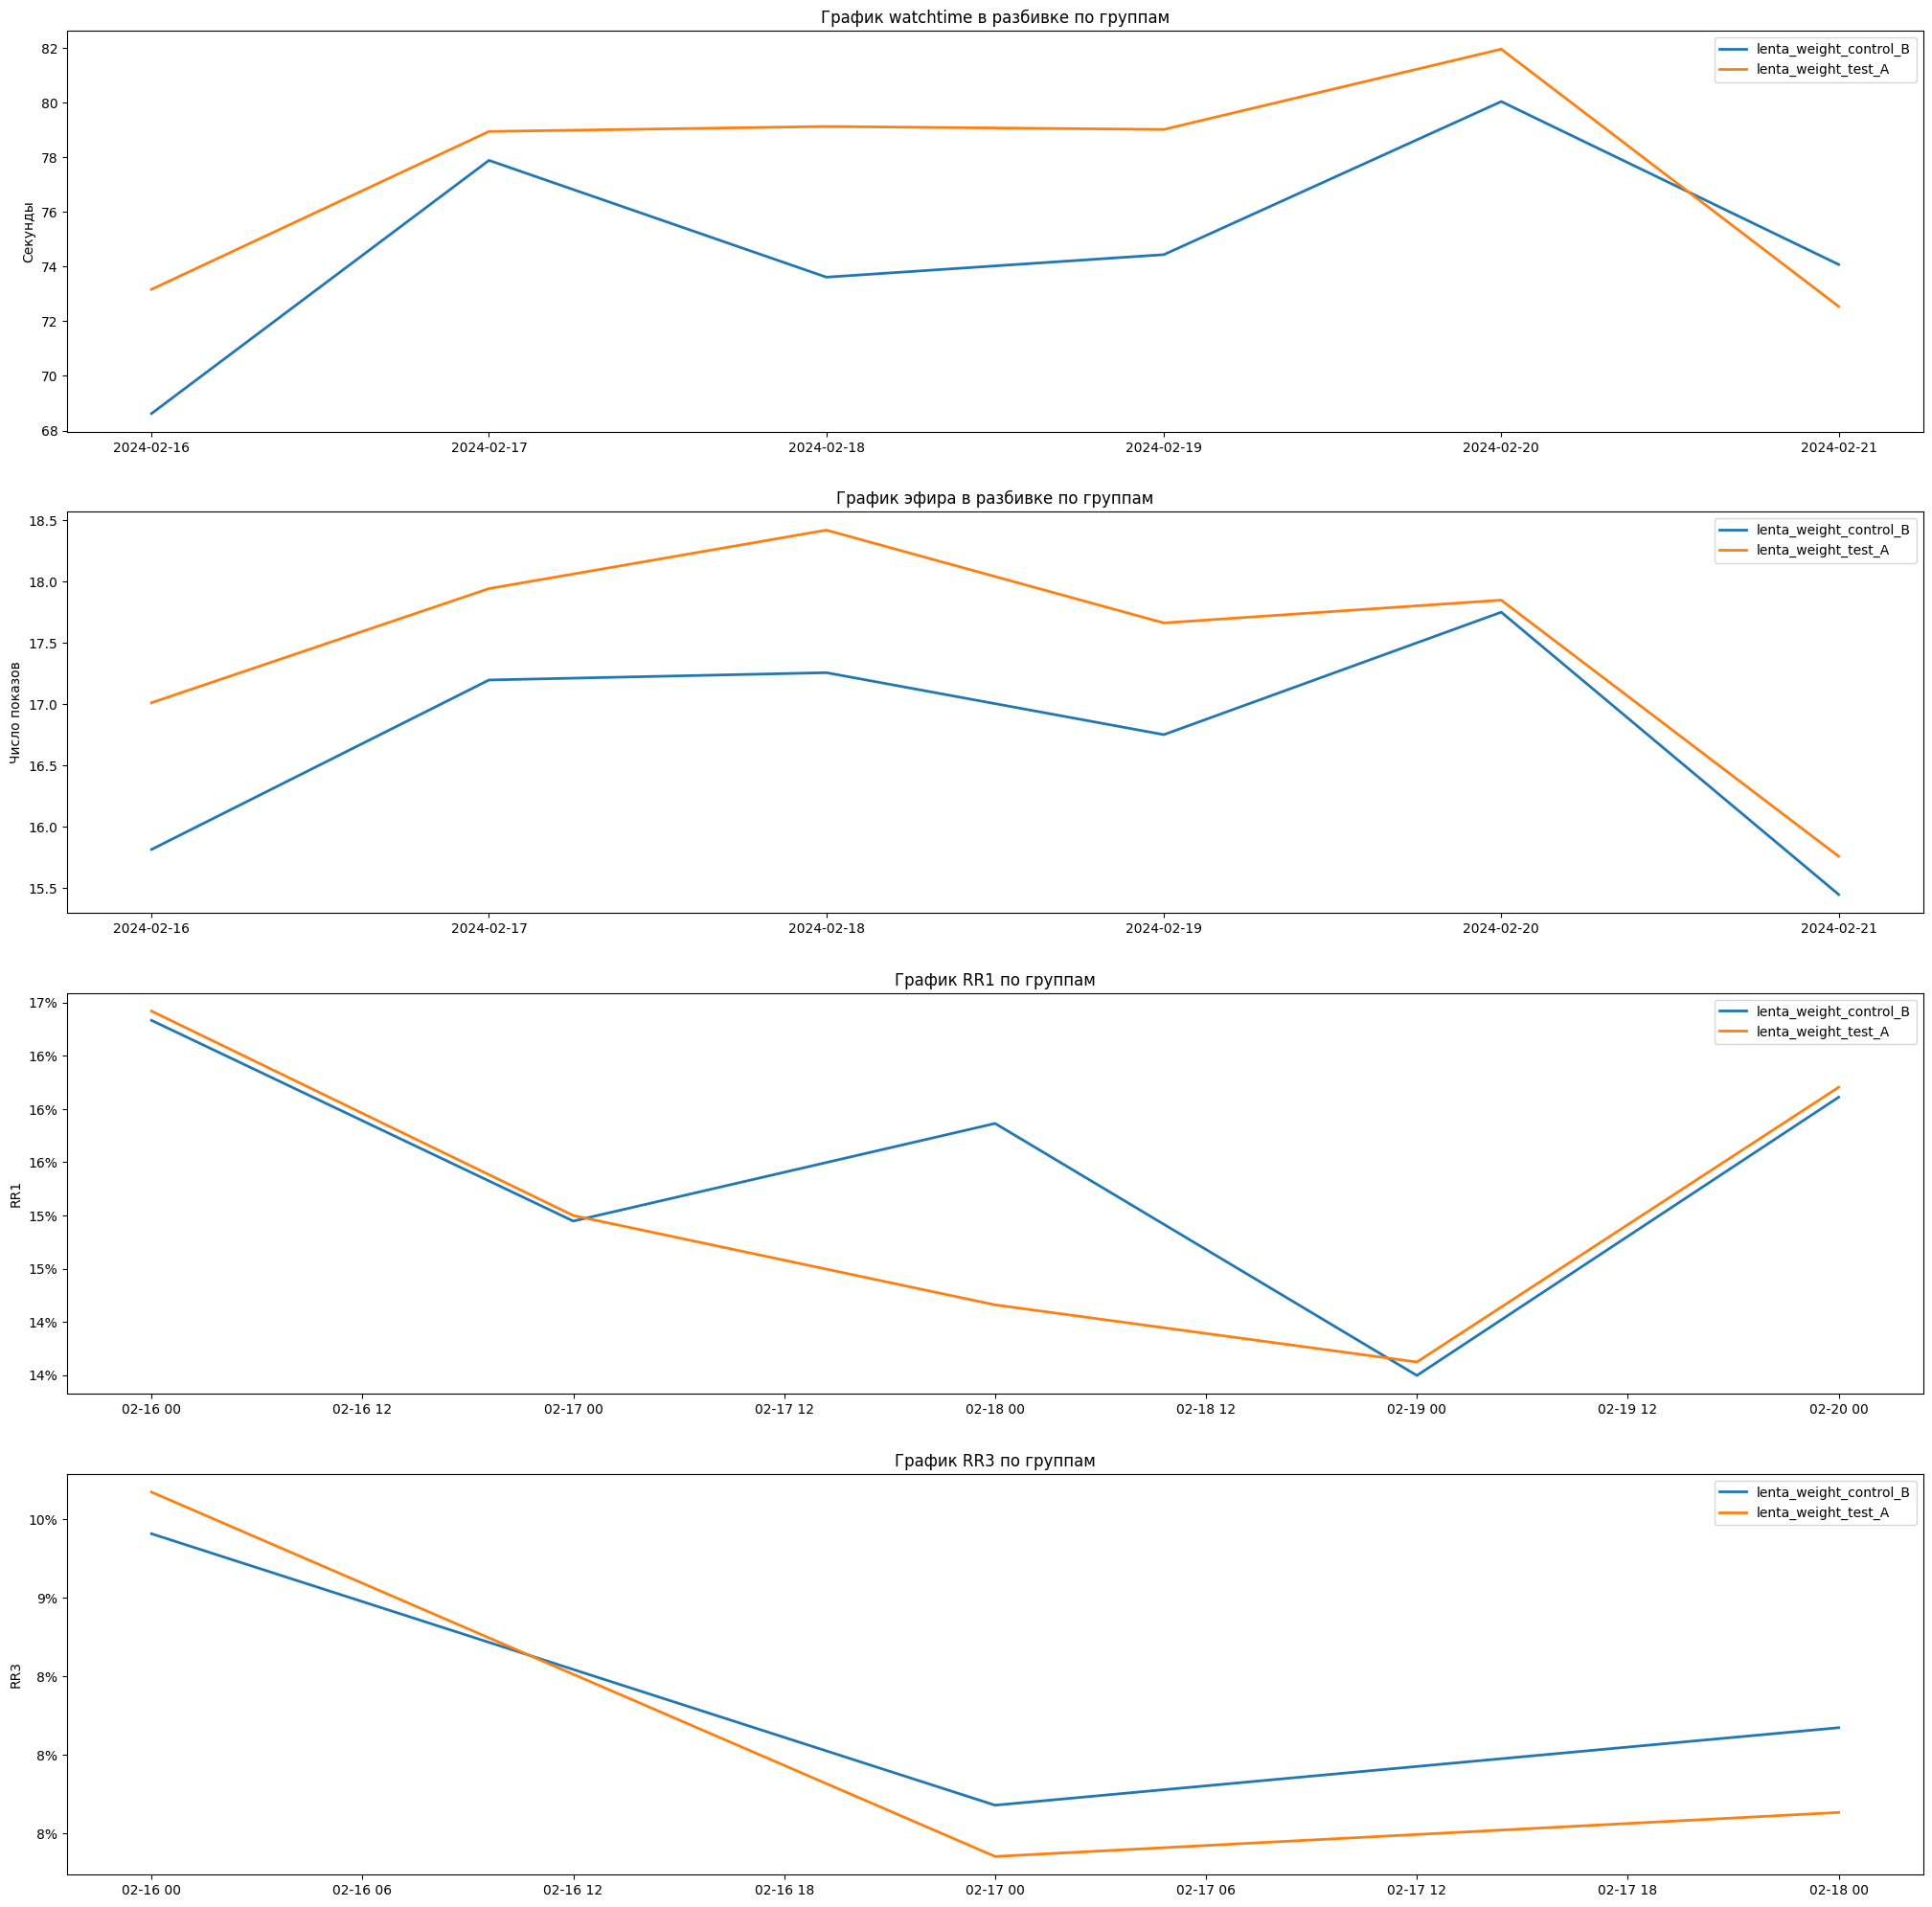

In [24]:
fix,axes = plt.subplots(4,1,figsize=(25,25))

# цикл по всем значениям experiment group
for i in df_unregister_agg['experiment_group'].unique():
    t = df_unregister_agg[df_unregister_agg['experiment_group']==i]

    axes[0].plot(t['date_msk'], t['watchtime'], label=i,linewidth=2)
    axes[1].plot(t['date_msk'], t['broadcast'], label=i,linewidth=2)
    
for i in df_unregister_first_date_agg['experiment_group'].unique():
    t1 = df_unregister_first_date_agg[df_unregister_first_date_agg['experiment_group']==i]
    axes[2].plot(t1['first_date_in_app'], t1['conv'], label=i,linewidth=2)
    

for i in df_unregister_third_date_agg['experiment_group'].unique():
    t3 = df_unregister_third_date_agg[df_unregister_third_date_agg['experiment_group']==i]
    axes[3].plot(t3['first_date_in_app'], t3['conv'], label=i,linewidth=2)
    


# Увеличиваем расстояние между графиками
plt.subplots_adjust(hspace=0.2)    

axes[0].set_title('График watchtime в разбивке по группам')
axes[0].legend()
axes[0].set_ylabel('Секунды')


axes[1].set_title('График эфира в разбивке по группам')
axes[1].legend()
axes[1].set_ylabel('Число показов')

axes[2].set_title('График RR1 по группам')
axes[2].legend()
axes[2].set_ylabel('RR1')
axes[2].yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1, decimals=0))

axes[3].set_title('График RR3 по группам')
axes[3].legend()
axes[3].set_ylabel('RR3')
axes[3].yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1, decimals=0))

plt.show()

## Тест на независимость 

In [25]:
# Функция для хи-квадра по определению независимости между выборками
def chi_independence(df, control, test_1, segment_name, part=None):
        '''H0: distributions are independent, H1: distributions are dependent '''
        for segment in segment_name:
                control1 = df[df['experiment_group'] == control][segment].value_counts()
                test1 = df[df['experiment_group'] == test_1][segment].value_counts()
                # test2 = df[df['experiment_group'] == test_2][segment].value_counts()
                # test3 = df[df['experiment_group'] == test_3][segment].value_counts()
                
                #concat = pd.concat([control1,test1,test2,test3], axis=1)
                #concat.columns = ['control_1','test_1','test_2','test_3']
                concat = pd.concat([control1,test1], axis=1)
                concat.columns = ['control','test_1']
                if part:
                    print(concat.iloc[:part])
                    stat, p_value, dof, expected = stats.chi2_contingency(concat.iloc[:part])
                else:
                    stat, p_value, dof, expected = stats.chi2_contingency(concat)

                if p_value <= 0.01:
                        print (f" {segment}- p-value: {p_value:.4f}, statistic: {stat:.4f}, dof: {dof}, dependent (reject H0)\n")
                else:
                        print (f" {segment} - p-value: {p_value:.4f}, statistic: {stat:.4f}, dof: {dof}, independent (fail to reject H0)\n")


In [26]:
chi_independence(df_unregister,
                  control_group,
                  test_group_1,
                  #test_group_2,
                  #test_group_3,
                 ["os_name","country_type","device_manufacturer","device_model","app_version_name","os_version"],
                 15
                )

         control  test_1
os_name                 
1          75926   75328
0            982     983
 os_name - p-value: 0.8620, statistic: 0.0302, dof: 1, independent (fail to reject H0)

              control  test_1
country_type                 
Россия          67640   67268
СНГ              3593    3518
Остальные         556     556
 country_type - p-value: 0.8103, statistic: 0.4208, dof: 2, independent (fail to reject H0)

                      control   test_1
device_manufacturer                   
Redmi                 29255.0  28705.0
Samsung                9700.0   9874.0
Xiaomi                 6357.0   6384.0
Huawei                 6185.0   6244.0
Realme                 5076.0   5025.0
POCO                   4384.0   4227.0
Tecno                  2324.0   2395.0
Infinix                1840.0   1756.0
Oppo                    941.0    939.0
Apple                   926.0    936.0
Honor                   870.0    902.0
Vivo                    693.0    630.0
TECNO MOBILE LIMITED   

## Тест на SRM (тест на однородность)

In [27]:
def chi_homogeneity(df, control, test_1, segment_name,number_of_groups, part=None):
    '''H0: distributions are homogeneous, H1: distributions are not homogeneous '''
    for segment in segment_name:
            control1 = df[df['experiment_group'] == control][segment].value_counts()
            test1 = df[df['experiment_group'] == test_1][segment].value_counts()
            # test2 = df[df['experiment_group'] == test_2][segment].value_counts()
            # test3 = df[df['experiment_group'] == test_3][segment].value_counts()
            concat = pd.concat([control1,test1], axis=1)
            concat.columns = ['control_1','test_1']
            concat['expected']=concat.sum(axis=1).apply(lambda x: math.ceil(x / number_of_groups))
            print(concat.iloc[:part])
            for i in concat.columns[:-1]:
                    # рассчитываем статистику
                    k = len(concat[i].iloc[:part])                                                                                             # число степеней свободы 
                    statistic = (((concat[i].iloc[:part] - concat['expected'].iloc[:part])**2)/concat['expected'].iloc[:part]).sum()           # КСП
                    # рассчитываем p-value 
                    p_value = 1 - stats.chi2.cdf(statistic, k - 1)                                                                             # вероятность получить значение выше или равное статистике
                    if p_value <= 0.01:
                            print (f" {segment}- p-value: {p_value:.4f}, statistic: {statistic:.4f}, dof: {k-1}, homogenes (reject H0)\n")
                    else:
                            print (f" {segment} - p-value: {p_value:.4f}, statistic: {statistic:.4f}, dof: {k-1}, not homogenes (fail to reject H0)\n")


In [28]:
chi_homogeneity(df_unregister,
                  control_group,
                  test_group_1,
                  # test_group_2,
                  # test_group_3,
                  ["os_name","country_type","device_manufacturer","device_model","app_version_name","os_version"],
                 num_of_bucket, # Количество групп в тесте 
                 15)

         control_1  test_1  expected
os_name                             
1            75926   75328     75627
0              982     983       983
 os_name - p-value: 0.2767, statistic: 1.1831, dof: 1, not homogenes (fail to reject H0)

 os_name - p-value: 0.2769, statistic: 1.1821, dof: 1, not homogenes (fail to reject H0)

              control_1  test_1  expected
country_type                             
Россия            67640   67268     67454
СНГ                3593    3518      3556
Остальные           556     556       556
 country_type - p-value: 0.6383, statistic: 0.8979, dof: 2, not homogenes (fail to reject H0)

 country_type - p-value: 0.6316, statistic: 0.9190, dof: 2, not homogenes (fail to reject H0)

                      control_1   test_1  expected
device_manufacturer                               
Redmi                   29255.0  28705.0     28980
Samsung                  9700.0   9874.0      9787
Xiaomi                   6357.0   6384.0      6371
Huawei           

## Распределения 

In [29]:
def plot_segments_distribution(df, segment_columns, test_factor):
    for i in segment_columns:
        aggregated_data = df.groupby(by = [test_factor,i])['device_id'].count().reset_index()
        sns.catplot(x = i, 
                    y = 'device_id', 
                    hue = test_factor, # сообщаем, что хотим, чтобы разные группы имели разный цвет
                    data = aggregated_data.sort_values(by='device_id', ascending=False).iloc[:40], 
                    kind = "bar", 
                    height = 4, # задаем размер графика 
                    aspect = 1.5) # задаем ширину столбца
        plt.xticks(rotation=100)

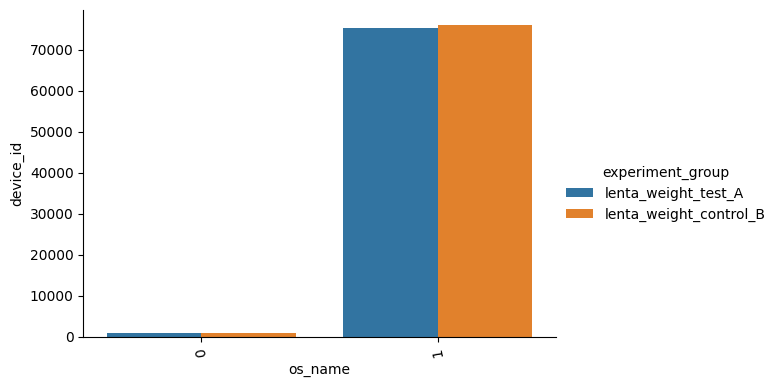

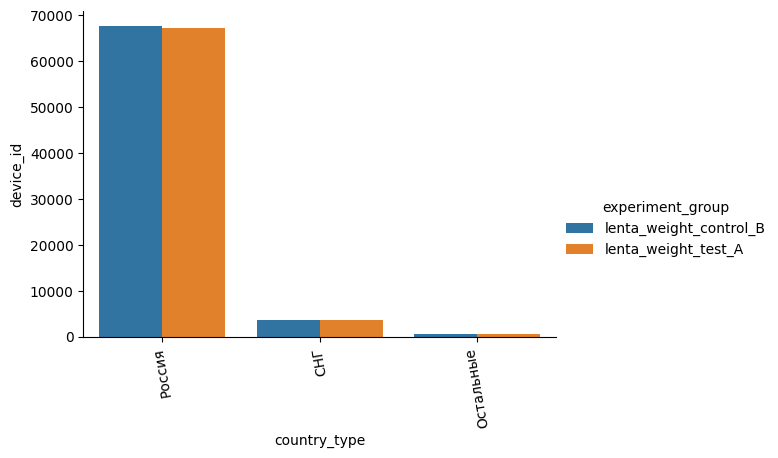

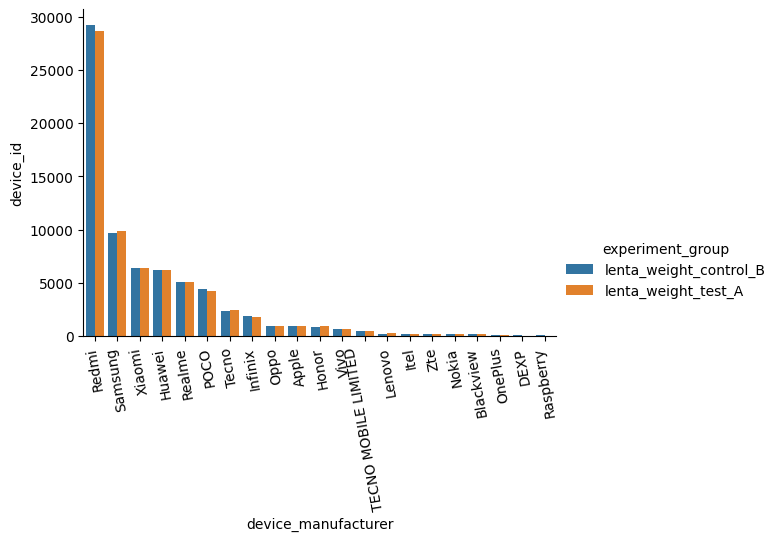

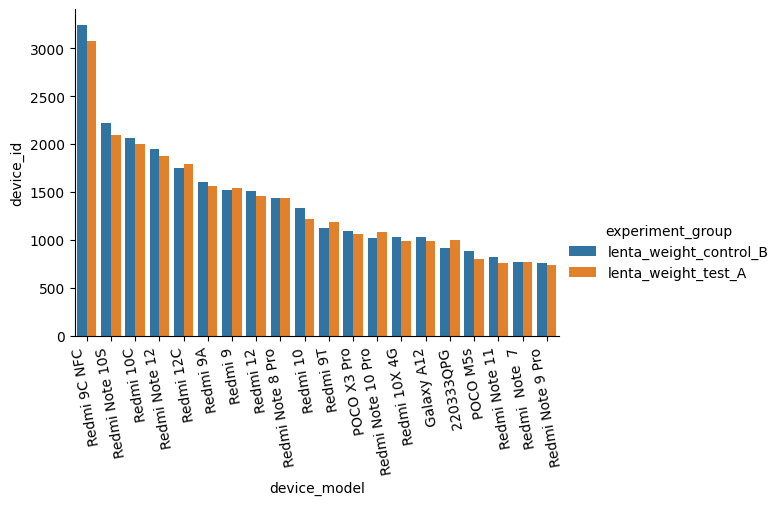

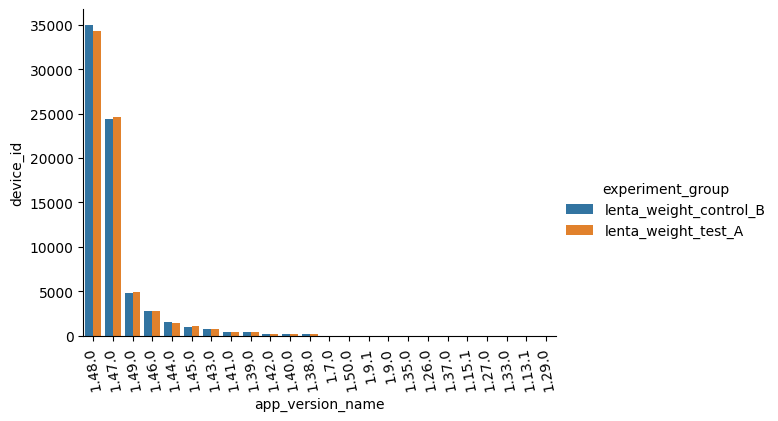

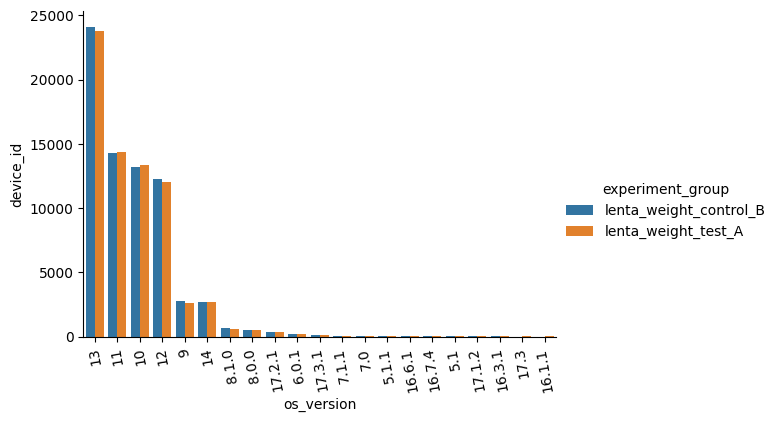

In [30]:
plot_segments_distribution(df_unregister, #датафрейм
                          ["os_name","country_type","device_manufacturer","device_model","app_version_name","os_version"],
                           "experiment_group",) #тест-фактор

## Квантильный анализ

In [31]:
df_unregister_agg = df_unregister.groupby(['device_id','os_name','os_version','app_version_name','device_manufacturer','device_model','country_type','experiment_group','first_date_in_app','d_0','d_1','d_3']).agg({'watchtime':'sum','broadcast':'sum'}).reset_index()
df_unregister_agg

,device_id,os_name,os_version,app_version_name,device_manufacturer,device_model,country_type,experiment_group,first_date_in_app,d_0,d_1,d_3,watchtime,broadcast
0,00007dfc-d1bd-3d80-b075-bc2d5b74505e,1,12,1.39.0,Realme,realme narzo 50A,Россия,lenta_weight_control_B,2000-01-01,0.0,0.0,0.0,0.000,4
1,00025980-6298-3840-8ac8-0283e93448f1,1,12,1.49.0,Xiaomi,Mi Note 10 Lite,Россия,lenta_weight_control_B,2000-01-01,0.0,0.0,0.0,5.554,1
2,000294e3-5770-3f9e-aa65-8529d49f2f32,1,9,1.48.0,Huawei,HONOR 8A Pro,Россия,lenta_weight_test_A,2024-02-17,1.0,0.0,0.0,774.511,159
3,0002b3ea-d1ef-32bd-b41b-6f25bd60bb77,1,13,1.48.0,Redmi,Redmi 12,Россия,lenta_weight_control_B,2024-02-19,1.0,0.0,0.0,8.329,1
4,00030ffe-18fb-3984-be74-908ebadabf07,1,9,1.48.0,Xiaomi,Redmi 6A,Россия,lenta_weight_test_A,2000-01-01,0.0,0.0,0.0,89.177,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
121612,fffd6563-03f7-30f9-9782-3f2b880210e8,1,11,1.48.0,Xiaomi,220333QPG,Россия,lenta_weight_test_A,2024-02-19,1.0,0.0,0.0,19.413,3
121613,fffd9e8e-a071-31a0-b6b9-01c3d435e7cc,1,13,1.47.0,Realme,RMX3710,Россия,lenta_weight_control_B,2024-02-20,1.0,0.0,0.0,61.405,14
121614,ffff756e-2513-37be-920a-896db88a3ef5,1,10,1.48.0,Xiaomi,Mi 9T,Россия,lenta_weight_test_A,2024-02-17,1.0,0.0,0.0,4.502,1
121615,ffffc7c0-9ba3-36e1-8815-49c0db195b70,1,11,1.47.0,Redmi,Redmi Note 8 Pro,Россия,lenta_weight_control_B,2000-01-01,0.0,0.0,0.0,19.217,3


In [32]:
df_unregister_agg['watchtime'].var()

178223.37293685263

In [33]:
print(df_unregister_agg['device_id'].count())
print(df_unregister_agg['device_id'].nunique())

121617
121617


In [34]:
quantiles=[1,2,3,4,5,6,7,8,9,10,25,50,75,80,85,90,91,92,93,94,95,96,97,98,99]
columns = ['watchtime','broadcast']


# пустой df для хранения результатов
quantiles_data = pd.DataFrame(index=quantiles, columns=columns)

for i in columns:
    data = df_unregister_agg[i].dropna()
    quantile_values = np.percentile(data, quantiles)
    quantiles_data[i] = quantile_values

quantiles_data

,watchtime,broadcast
1,0.00000,1.0
2,0.00000,1.0
3,0.00000,1.0
4,0.00000,1.0
5,0.00000,1.0
6,0.00000,1.0
7,0.14700,1.0
8,0.60100,1.0
9,0.95100,1.0
10,1.20700,1.0


In [35]:
# Убираем 95 квантиль 
df_unregister_agg_wo_outlier = df_unregister_agg[(df_unregister_agg['watchtime']<np.percentile(df_unregister_agg['watchtime'],95))]


# df_svr_merge_agg_wo_outlier_start = df_svr_merge_agg_start[(df_svr_merge_agg_start['watchtime']<np.percentile(df_svr_merge_agg_start['watchtime'],95))]
# df_svr_merge_agg_wo_outlier_stairs = df_svr_merge_agg_stairs[(df_svr_merge_agg_stairs['watchtime']<np.percentile(df_svr_merge_agg_stairs['watchtime'],95))]
# df_svr_merge_agg_wo_outlier_actual = df_svr_merge_agg_actual[(df_svr_merge_agg_actual['watchtime']<np.percentile(df_svr_merge_agg_actual['watchtime'],95))]

In [36]:
df_unregister_agg_wo_outlier['watchtime'].var()

3870.074126320966

In [37]:
grouped_df = df_unregister_agg_wo_outlier.groupby('experiment_group').agg({'device_id':'count'})
total_count = grouped_df['device_id'].sum()
grouped_df.loc['Total'] = [total_count]
grouped_df

,device_id
experiment_group,
lenta_weight_control_B,58097
lenta_weight_test_A,57439
Total,115536


In [38]:
df_unregister_agg.groupby('experiment_group')['watchtime'].mean()

experiment_group
lenta_weight_control_B    92.819632
lenta_weight_test_A       96.744917
Name: watchtime, dtype: float64

In [39]:
df_unregister_agg_wo_outlier.groupby('experiment_group')['watchtime'].mean()

experiment_group
lenta_weight_control_B    42.965641
lenta_weight_test_A       42.973944
Name: watchtime, dtype: float64

## Функция бутстрапа

In [40]:
def get_bootstrap(
    data_column_1, # числовые значения первой выборки
    data_column_2, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95, # уровень значимости
    alpha=0.05
):
    boot_len = max([len(data_column_1), len(data_column_2)])
    boot_data = []
    for i in tqdm(range(boot_it)): # извлекаем подвыборки
        samples_1 = data_column_1.sample(boot_len, replace = True).values
        samples_2 = data_column_2.sample(boot_len, replace = True).values
        boot_data.append(statistic(samples_1-samples_2))
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    quants = pd_boot_data.quantile([left_quant, right_quant])
    ci = np.percentile(pd_boot_data, [alpha/2*100, (1-alpha/2)*100])
        
    p_1 = norm.cdf(x = 0,loc = np.mean(boot_data),scale = np.std(boot_data))
    p_2 = norm.cdf(x = 0,loc = -np.mean(boot_data),scale = np.std(boot_data))
    p_value = min(p_1, p_2) * 2
    return {#"Доверительный интервал":str(ci),
            "p_value": round(p_value,3)}


## Деление на группы эксперимента

In [41]:
control = df_unregister_agg_wo_outlier[df_unregister_agg_wo_outlier['experiment_group']==control_group]
test_1 = df_unregister_agg_wo_outlier[df_unregister_agg_wo_outlier['experiment_group']==test_group_1]

# start_select_control_1 = df_start_select_agg_megre_wo_outlier_agg[df_start_select_agg_megre_wo_outlier_agg['experiment_group']==control_group_1]
# start_select_test_1 = df_start_select_agg_megre_wo_outlier_agg[df_start_select_agg_megre_wo_outlier_agg['experiment_group']==test_group_1]
# start_select_test_2 = df_start_select_agg_megre_wo_outlier_agg[df_start_select_agg_megre_wo_outlier_agg['experiment_group']==test_group_2]
# start_select_test_3 = df_start_select_agg_megre_wo_outlier_agg[df_start_select_agg_megre_wo_outlier_agg['experiment_group']==test_group_3]


# control_1_start = df_svr_merge_agg_wo_outlier_start[df_svr_merge_agg_wo_outlier_start['experiment_group']==control_group_1]
# test_1_start = df_svr_merge_agg_wo_outlier_start[df_svr_merge_agg_wo_outlier_start['experiment_group']==test_group_1]

# control_1_stairs = df_svr_merge_agg_wo_outlier_stairs[df_svr_merge_agg_wo_outlier_stairs['experiment_group']==control_group_1]
# test_1_stairs = df_svr_merge_agg_wo_outlier_stairs[df_svr_merge_agg_wo_outlier_stairs['experiment_group']==test_group_1]


# control_1_actual = df_svr_merge_agg_wo_outlier_actual[df_svr_merge_agg_wo_outlier_actual['experiment_group']==control_group_1]
# test_1_actual = df_svr_merge_agg_wo_outlier_actual[df_svr_merge_agg_wo_outlier_actual['experiment_group']==test_group_1]

## Постстратификация

In [42]:
def calculate_strat_var(df, weights):
    """Вычисляет стратифицированную дисперсию."""
    strat_vars = df.groupby('device_model')['watchtime'].var()
    df_vars_weights = pd.merge(
        strat_vars,
        pd.Series(weights, name='weight'),
        how='inner',
        left_index=True,
        right_index=True
    )
    # если в данных df не было каких-то страт, то часть weights затрётся и сумма весов будет меньше 1
    df_vars_weights['weight'] = df_vars_weights['weight'] / df_vars_weights['weight'].sum()
    var_strat = (df_vars_weights['weight'] * df_vars_weights['watchtime']).sum()
    return var_strat

In [43]:
def calculate_stratified_mean(df, weights):
    """Вычисляет стратифицированное среднее.

    df - датафрейм с целевой метрикой и данными для стратификации
    weights - словарь - {название страты: вес страты}

    return: float, mean_strat
    """
    strat_mean = df.groupby('device_model')['watchtime'].mean()
    df_means_weights = pd.merge(
        strat_mean,
        pd.Series(weights, name='weight'),
        how='inner',
        left_index=True,
        right_index=True
    )
    # если в данных df не было каких-то страт, то часть weights затрётся и сумма весов будет меньше 1
    df_means_weights['weight'] = df_means_weights['weight'] / df_means_weights['weight'].sum()
    mean_strat = (df_means_weights['weight'] * df_means_weights['watchtime']).sum()
    return mean_strat

In [44]:
def check_stratified_test(df_control, df_pilot, weights):
    """Проверяет гипотезу о равенстве средних для стратифицированного среднего.
    
    return - pvalue.
    """
    mean_strat_control = calculate_stratified_mean(df_control, weights)
    mean_strat_pilot = calculate_stratified_mean(df_pilot, weights)
    var_strat_control = calculate_strat_var(df_control, weights)
    var_strat_pilot = calculate_strat_var(df_pilot, weights)
    delta_mean_strat = mean_strat_pilot - mean_strat_control
    std_mean_strat = (var_strat_pilot / len(df_pilot) + var_strat_control / len(df_control)) ** 0.5
    t = delta_mean_strat / std_mean_strat
    pvalue = (1 - stats.norm.cdf(np.abs(t))) * 2
    return pvalue,var_strat_control

In [45]:
weights = df_unregister_agg['device_model'].value_counts(normalize=True).to_dict()

print(calculate_strat_var(test_1,weights))
print(test_1['watchtime'].var())


3728.9973618600775
3847.3166030325237


In [46]:
print(calculate_stratified_mean(test_1,weights))
print(test_1['watchtime'].mean())      

43.11839633502738
42.97394357492296


## Retention 1-го дня

In [48]:
# Удаляем пустые строки, чтобы оставить новичков и посмотреть их retention 
df_retention_day_1 = df_unregister_agg_wo_outlier[(df_unregister_agg_wo_outlier['first_date_in_app']!='2000-01-01') & (df_unregister_agg_wo_outlier['first_date_in_app']<=day_retention_1_day)]
print("Количество дней для расчета retention 1-го дня:", df_retention_day_1['first_date_in_app'].nunique())


# Разбили на группы и проверяем сплитование 
control_retention_1_day = df_retention_day_1[df_retention_day_1['experiment_group'] == control_group]
test_1_retention_1_day = df_retention_day_1[df_retention_day_1['experiment_group'] == test_group_1]

# plot_segments_distribution(df_retention_day_1, #датафрейм
#                            ["os_name","country_type","device_manufacturer","device_model","app_version_name","os_version"],
#                            "experiment_group") #тест-фактор

Количество дней для расчета retention 1-го дня: 5


In [49]:
# # Retention 1-го дня
# metrics = df_retention.groupby('experiment_group', as_index= False).agg({'d_1':'sum', 'd_0':'sum'})
# metrics['conv'] = metrics['d_1'] / metrics['d_0'] * 100
# print(metrics)
# print()
# print('z-test AB групп',ztest(control_1_retention['d_1'],control_2_retention['d_1']))
# print('z-test AC групп',ztest(control_1_retention['d_1'],test_1_retention['d_1']))
# print('z-test AD групп',ztest(control_1_retention['d_1'],test_2_retention['d_1']))

## Retention 3-го дня

In [50]:
# Удаляем пустые строки, чтобы оставить новичков и посмотреть их retention 
df_retention_3_day = df_unregister_agg_wo_outlier[(df_unregister_agg_wo_outlier['first_date_in_app']!='2000-01-01') & (df_unregister_agg_wo_outlier['first_date_in_app']<=day_retention_3_day)]
print("Количество дней для расчета retention 3-го дня:", df_retention_3_day['first_date_in_app'].nunique())

# Разбили на группы и проверяем сплитование 
control_retention_3_day = df_retention_3_day[df_retention_3_day['experiment_group']== control_group]
test_1_retention_3_day = df_retention_3_day[df_retention_3_day['experiment_group']== test_group_1]

# plot_segments_distribution(df_retention_3_day, #датафрейм
#                            ["os_name","country_type","device_manufacturer","device_model","app_version_name","os_version"],
#                            "experiment_group") #тест-фактор

Количество дней для расчета retention 3-го дня: 3


## Подсчет среднего и расчет критериев

In [52]:
weights = df_unregister_agg['device_model'].value_counts(normalize=True).to_dict()

broadcast_control = control['broadcast'].mean()
broadcast_test_1 = test_1['broadcast'].mean()
broadcast_ttest_control_to_test1 = ttest_ind(control['broadcast'],test_1['broadcast'],equal_var=False)[1]


watchtime_control = calculate_stratified_mean(control,weights)
watchtime_test_1 = calculate_stratified_mean(test_1,weights)
watchtime_ttest_control_to_test1 = check_stratified_test(control,test_1,weights)[0]




retention_1_day_control = control_retention_1_day['d_1'].mean() * 100
retention_1_day_test_1 = test_1_retention_1_day['d_1'].mean() * 100
retention_1_day_ttest_control_to_test1 = ttest_ind(control_retention_1_day['d_1'],test_1_retention_1_day['d_1'],equal_var=False)[1]



retention_3_day_control = control_retention_3_day['d_3'].mean() * 100
retention_3_day_test_1 = test_1_retention_3_day['d_3'].mean() * 100
retention_3_day_ttest_control_to_test1 = ttest_ind(control_retention_3_day['d_3'],test_1_retention_3_day['d_3'],equal_var=False)[1]



# register_control_1 = control_1['profile_type_2'].mean() * 100
# register_test_1 = test_1['profile_type_2'].mean() * 100
# register_test_2 = test_2['profile_type_2'].mean() * 100
# register_test_3 = test_3['profile_type_2'].mean() * 100
# register_ttest_control_to_test1 = ttest_ind(control_1['profile_type_2'],test_1['profile_type_2'],equal_var=False)[1]
# register_ttest_control_to_test2 = ttest_ind(control_1['profile_type_2'],test_2['profile_type_2'],equal_var=False)[1]
# register_ttest_control_to_test3 = ttest_ind(control_1['profile_type_2'],test_3['profile_type_2'],equal_var=False)[1]



# watchtime_start_select_control_1 = start_select_control_1['watchtime'].mean()
# watchtime_start_test_1 = start_select_test_1['watchtime'].mean()
# watchtime_start_test_2 = start_select_test_2['watchtime'].mean()
# watchtime_start_test_3 = start_select_test_3['watchtime'].mean()
# watchtime_start_ttest_control_to_test1 = ttest_ind(start_select_control_1['watchtime'],start_select_test_1['watchtime'],equal_var=False)[1]
# watchtime_start_ttest_control_to_test2 = ttest_ind(start_select_control_1['watchtime'],start_select_test_2['watchtime'],equal_var=False)[1]
# watchtime_start_ttest_control_to_test3 = ttest_ind(start_select_control_1['watchtime'],start_select_test_3['watchtime'],equal_var=False)[1]




# watchtime_control_1_start = control_1_start['watchtime'].mean()
# watchtime_test_1_start = test_1_start['watchtime'].mean()
# watchtime_ttest_control_to_test1_start = ttest_ind(control_1_start['watchtime'],test_1_start['watchtime'],equal_var=False)[1]


# watchtime_control_1_stairs = control_1_stairs['watchtime'].mean()
# watchtime_test_1_stairs = test_1_stairs['watchtime'].mean()
# watchtime_ttest_control_to_test1_stairs = ttest_ind(control_1_stairs['watchtime'],test_1_stairs['watchtime'],equal_var=False)[1]


# watchtime_control_1_actual = control_1_actual['watchtime'].mean()
# watchtime_test_1_actual = test_1_actual['watchtime'].mean()
# watchtime_ttest_control_to_test1_actual = ttest_ind(control_1_actual['watchtime'],test_1_actual['watchtime'],equal_var=False)[1]


# metrics_1_day = df_retention_day_1.groupby('experiment_group', as_index= False).agg({'d_1':'sum', 'd_0':'sum'})
# metrics_1_day['conv'] = metrics_1_day['d_1'] / metrics_1_day['d_0'] * 100
# retention_1day_control_1 = metrics_1_day.loc[0,'conv']
# retention_1day_test_1 = metrics_1_day.loc[1,'conv']
# retention_1day_test_2 = metrics_1_day.loc[2,'conv']
# retention_1day_test_3 = metrics_1_day.loc[3,'conv']
# retention1day_control_to_test1 = ztest(control_1_retention_1_day['d_1'],test_1_retention_1_day['d_1'])[1]
# retention1day_control_to_test2 = ztest(control_1_retention_1_day['d_1'],test_2_retention_1_day['d_1'])[1]
# retention1day_control_to_test3 = ztest(control_1_retention_1_day['d_1'],test_3_retention_1_day['d_1'])[1]


# metrics_3_day = df_retention_3_day.groupby('experiment_group', as_index= False).agg({'d_3':'sum', 'd_0':'sum'})
# metrics_3_day['conv'] = metrics_3_day['d_3'] / metrics_3_day['d_0'] * 100
# retention_3day_control_1 = metrics_3_day.loc[0,'conv']
# retention_3day_test_1 = metrics_3_day.loc[1,'conv']
# retention_3day_test_2 = metrics_3_day.loc[2,'conv']
# retention_3day_test_3 = metrics_3_day.loc[3,'conv']
# retention3day_control_to_test1=ztest(control_1_retention_3_day['d_3'],test_1_retention_3_day['d_3'])[1]
# retention3day_control_to_test2=ztest(control_1_retention_3_day['d_3'],test_2_retention_3_day['d_3'])[1]
# retention3day_control_to_test3=ztest(control_1_retention_3_day['d_3'],test_3_retention_3_day['d_3'])[1]



## Симмуляция Монте-Карло для контроля ошибок I и II рода

In [53]:
def mde_estimated_absolute (ttl_users,var,alpha,beta):
        t_alpha = stats.norm.ppf(1 - alpha / 3 / 2, loc=0, scale=1)
        t_beta = stats.norm.ppf(1 - beta, loc=0, scale=1)
        var = 2 * var
        MDE=(t_alpha+t_beta) * np.sqrt(var  / ttl_users)
        return MDE

In [54]:
ttl_users = math.ceil(df_unregister_agg_wo_outlier['device_id'].nunique()/num_of_bucket)
var = control['watchtime'].var()
mean = control['watchtime'].mean()
mde_absolute=mde_estimated_absolute(ttl_users,var,0.05,0.2)
MDE = mde_absolute / mean

print('MDE абсолютный:',round(mde_absolute,4))
print('MDE относительный:',round(MDE,4))
print('Средний watchtime за неделю:',round(mean,4))
print('Дисперсия',round(var,4)) 
print('Число пользователей',math.ceil(ttl_users))

MDE абсолютный: 1.1878
MDE относительный: 0.0276
Средний watchtime за неделю: 42.9656
Дисперсия 3892.6405
Число пользователей 57768


100%|██████████| 1000/1000 [00:22<00:00, 45.12it/s]


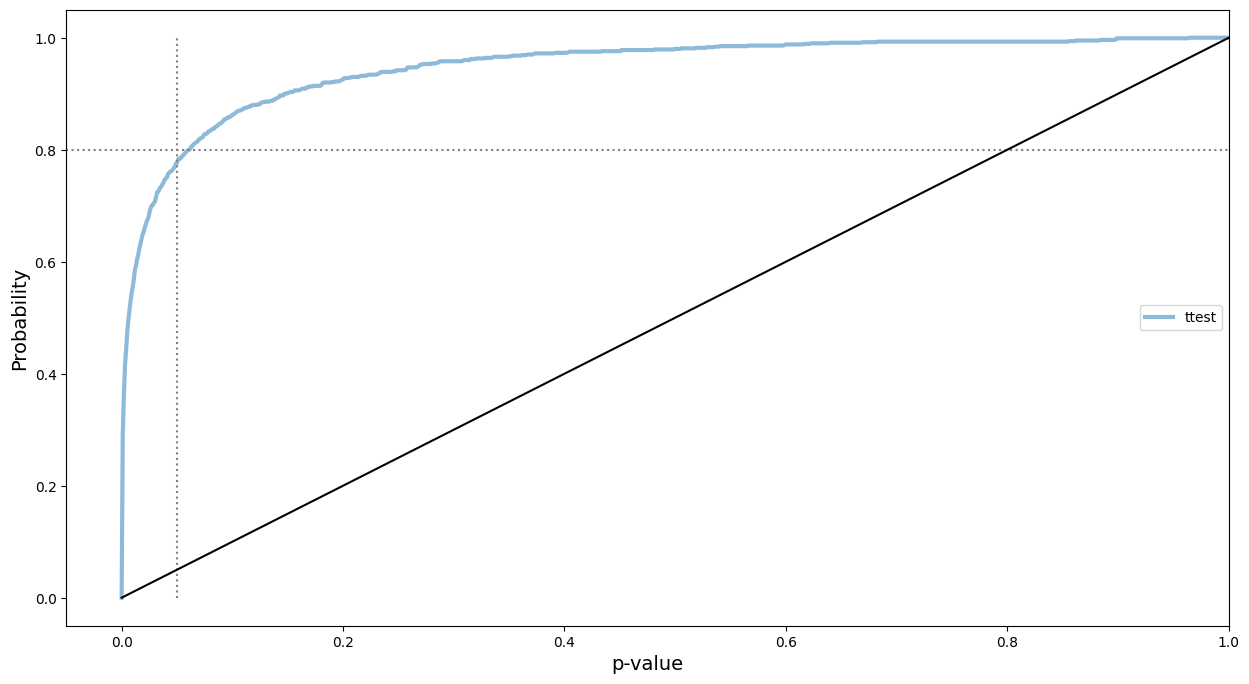

In [56]:
ttl_users = math.ceil(df_unregister_agg_wo_outlier['device_id'].nunique()/num_of_bucket)
effect = 1
pvalues_ttest = []
mean = []
for i in tqdm(range(1000)):
    
        df_control_wo_outlier = df_unregister_agg_wo_outlier.sample(n = ttl_users,replace=True)
        df_pilot_wo_outlier = df_unregister_agg_wo_outlier.sample(n = ttl_users,replace=True)
        df_pilot_wo_outlier['watchtime'] += effect
        means = df_pilot_wo_outlier['watchtime'].mean()
        pvalue = stats.ttest_ind(df_control_wo_outlier['watchtime'], df_pilot_wo_outlier['watchtime'])[1]
        
        pvalues_ttest.append(pvalue)
        mean.append(means)
        
list_pvalues = [pvalues_ttest]
list_titles = ['ttest']
plt.figure(figsize=(15,8))

X = np.linspace(0, 1, 1000)
for pvalues, title in zip(reversed(list_pvalues), reversed(list_titles)):
    pvalues = np.array(pvalues)
    Y = [np.mean(pvalues < x) for x in X]
    plt.plot(X, Y, alpha=0.5, linewidth=3, label=title)
plt.xlabel('pvalue')
x_values = [0.05/(num_of_bucket - 1)]
plt.vlines(x_values, ymin=0, ymax=1, linestyles='dotted', colors='gray')
plt.axhline(y=0.8, color='gray', linestyle='dotted')
plt.xlim([-0.05, 1])
plt.xlabel('p-value', size=14)
plt.ylabel('Probability', size=14)
plt.plot([0, 1], [0, 1], 'k')
plt.legend(loc=5)
plt.show()        

In [57]:
final_table_register = []

row1 = [watchtime_control, watchtime_test_1, watchtime_ttest_control_to_test1]
row2 = [broadcast_control, broadcast_test_1, broadcast_ttest_control_to_test1]

# row3 = [watchtime_control_1_start, watchtime_test_1_start, watchtime_ttest_control_to_test1_start]
# row4 = [watchtime_control_1_stairs, watchtime_test_1_stairs, watchtime_ttest_control_to_test1_stairs]
# row5 = [watchtime_control_1_actual, watchtime_test_1_actual, watchtime_ttest_control_to_test1_actual]

row6 = [retention_1_day_control, retention_1_day_test_1, retention_1_day_ttest_control_to_test1] 
row7 = [retention_3_day_control, retention_3_day_test_1, retention_3_day_ttest_control_to_test1]

# row8 = [register_control_, register_test_1, register_test_2, register_test_3, register_ttest_control_to_test1, register_ttest_control_to_test2, register_ttest_control_to_test3]
# row9 = [watchtime_start_select_control_1, watchtime_start_test_1, watchtime_start_test_2, watchtime_start_test_3, watchtime_start_ttest_control_to_test1, watchtime_start_ttest_control_to_test2, watchtime_start_ttest_control_to_test3]


final_table_register.append(row1)
final_table_register.append(row2)
# final_table_register.append(row3)
# final_table_register.append(row4)
# final_table_register.append(row5)
final_table_register.append(row6)
final_table_register.append(row7)
# final_table_register.append(row8)
# final_table_register.append(row9)





final_table_register = pd.DataFrame(final_table_register, index=['Watchtime за 7 дней, сек','Эфир за 7 дней', 'Retention 1-го дня, %','Retention 3-го дня, %'], columns=['контроль', 'тест 1', 'тест 1 к контролю'])

final_table_register['тест 1 к контролю']=np.where(final_table_register['тест 1 к контролю'].isna(), 0, np.where(final_table_register['тест 1 к контролю']<0.05/num_of_bucket, round((final_table_register['тест 1'] / final_table_register['контроль'] - 1) * 100,2), 'Нет различия'))
# final_table_register['тест 2 к контролю']=np.where(final_table_register['тест 2 к контролю'].isna(), 0, np.where(final_table_register['тест 2 к контролю']<0.05/num_of_bucket, round((final_table_register['тест 2'] / final_table_register['контроль'] - 1) * 100,2), 'Нет различия'))
# final_table_register['тест 3 к контролю']=np.where(final_table_register['тест 3 к контролю'].isna(), 0, np.where(final_table_register['тест 3 к контролю']<0.05/num_of_bucket, round((final_table_register['тест 3'] / final_table_register['контроль'] - 1) * 100,2), 'Нет различия'))
final_table_register

,контроль,тест 1,тест 1 к контролю
"Watchtime за 7 дней, сек",43.134710,43.118396,Нет различия
Эфир за 7 дней,10.699692,10.704713,Нет различия
"Retention 1-го дня, %",8.661053,8.785972,Нет различия
"Retention 3-го дня, %",4.104341,4.226065,Нет различия


In [58]:
final_table_register['тест 1 к контролю']= np.where(final_table_register['тест 1 к контролю']=='Нет различия',final_table_register['тест 1 к контролю'], np.where(final_table_register['тест 1 к контролю'].str.contains('-'),final_table_register['тест 1 к контролю'] + '%','+' + final_table_register['тест 1 к контролю'] + '%'))
# final_table_register['тест 2 к контролю']= np.where(final_table_register['тест 2 к контролю']=='Нет различия',final_table_register['тест 2 к контролю'], np.where(final_table_register['тест 2 к контролю'].str.contains('-'),final_table_register['тест 2 к контролю'] + '%','+' + final_table_register['тест 2 к контролю'] + '%'))
# final_table_register['тест 3 к контролю']= np.where(final_table_register['тест 3 к контролю']=='Нет различия',final_table_register['тест 3 к контролю'], np.where(final_table_register['тест 3 к контролю'].str.contains('-'),final_table_register['тест 3 к контролю'] + '%','+' + final_table_register['тест 3 к контролю'] + '%'))


## Фукнция для закраски ячеек

In [59]:
def color_cell(val):
    if val == 'Нет различия':
        return ''
    elif '+' in val:
        return 'background-color: lightgreen'
    else:
        return 'background-color:  #FFCCCB'

In [60]:
final_table_register[['контроль', 'тест 1','тест 1 к контролю']].style.applymap(color_cell, subset=['тест 1 к контролю'])

,контроль,тест 1,тест 1 к контролю
"Watchtime за 7 дней, сек",43.134710,43.118396,Нет различия
Эфир за 7 дней,10.699692,10.704713,Нет различия
"Retention 1-го дня, %",8.661053,8.785972,Нет различия
"Retention 3-го дня, %",4.104341,4.226065,Нет различия


# Зареги

In [61]:
df_register = df_merge[(df_merge['profile_type'] == 'Зарег') & (df_merge['empty_user'] == 0) & (df_merge['bot_flag']==0) & (df_merge['date_msk']>=start_date)]
df_register_agg = df_register.groupby(['date_msk','experiment_group']).agg({'watchtime':'mean','broadcast':'mean'}).reset_index()
df_register_agg

,date_msk,experiment_group,watchtime,broadcast
0,2024-02-16,lenta_weight_control_B,188.913069,46.020468
1,2024-02-16,lenta_weight_test_A,206.071444,49.069020
2,2024-02-17,lenta_weight_control_B,210.267515,51.037512
3,2024-02-17,lenta_weight_test_A,205.090493,49.691768
4,2024-02-18,lenta_weight_control_B,224.480364,52.437127
5,2024-02-18,lenta_weight_test_A,213.527899,53.026621
6,2024-02-19,lenta_weight_control_B,197.555847,46.340074
7,2024-02-19,lenta_weight_test_A,197.512590,48.487362
8,2024-02-20,lenta_weight_control_B,202.075349,47.895770
9,2024-02-20,lenta_weight_test_A,219.378451,51.005613


In [62]:
t1 = df_register.groupby('device_id')['watchtime'].sum().reset_index()
t1['watchtime'].var()

1058268.11091828

In [63]:
df_register.groupby('date_msk')['device_id'].nunique()

date_msk
2024-02-16    7587
2024-02-17    8182
2024-02-18    8156
2024-02-19    8654
2024-02-20    7180
2024-02-21    7640
Name: device_id, dtype: int64

In [64]:
df_register_first_date = df_register[(df_register['first_date_in_app']!='2000-01-01') & (df_register['first_date_in_app']<=day_retention_1_day)]
df_register_first_date['first_date_in_app'].unique()

df_register_first_date_agg = df_register_first_date.groupby(['first_date_in_app','experiment_group']).agg({'d_0':'sum','d_1':'sum'}).reset_index()
df_register_first_date_agg['conv'] = df_register_first_date_agg['d_1'] / df_register_first_date_agg['d_0']
df_register_first_date_agg

,first_date_in_app,experiment_group,d_0,d_1,conv
0,2024-02-16,lenta_weight_control_B,1471.0,538.0,0.365738
1,2024-02-16,lenta_weight_test_A,1640.0,664.0,0.404878
2,2024-02-17,lenta_weight_control_B,1693.0,573.0,0.338452
3,2024-02-17,lenta_weight_test_A,1658.0,567.0,0.341978
4,2024-02-18,lenta_weight_control_B,1576.0,564.0,0.357868
5,2024-02-18,lenta_weight_test_A,1619.0,616.0,0.380482
6,2024-02-19,lenta_weight_control_B,1381.0,484.0,0.350471
7,2024-02-19,lenta_weight_test_A,1329.0,419.0,0.315275
8,2024-02-20,lenta_weight_control_B,850.0,259.0,0.304706
9,2024-02-20,lenta_weight_test_A,924.0,306.0,0.331169


In [65]:
df_register_third_date = df_register[(df_register['first_date_in_app']!='2000-01-01') & (df_register['first_date_in_app']<=day_retention_3_day)]
df_register_third_date['first_date_in_app'].unique()

df_register_third_date_agg = df_register_third_date.groupby(['first_date_in_app','experiment_group']).agg({'d_0':'sum','d_3':'sum'}).reset_index()
df_register_third_date_agg['conv'] = df_register_third_date_agg['d_3'] / df_register_third_date_agg['d_0']
df_register_third_date_agg

,first_date_in_app,experiment_group,d_0,d_3,conv
0,2024-02-16,lenta_weight_control_B,1471.0,293.0,0.199184
1,2024-02-16,lenta_weight_test_A,1640.0,382.0,0.232927
2,2024-02-17,lenta_weight_control_B,1693.0,313.0,0.184879
3,2024-02-17,lenta_weight_test_A,1658.0,263.0,0.158625
4,2024-02-18,lenta_weight_control_B,1576.0,291.0,0.184645
5,2024-02-18,lenta_weight_test_A,1619.0,320.0,0.197653


## Метрики в динамике по группам экспериментам 

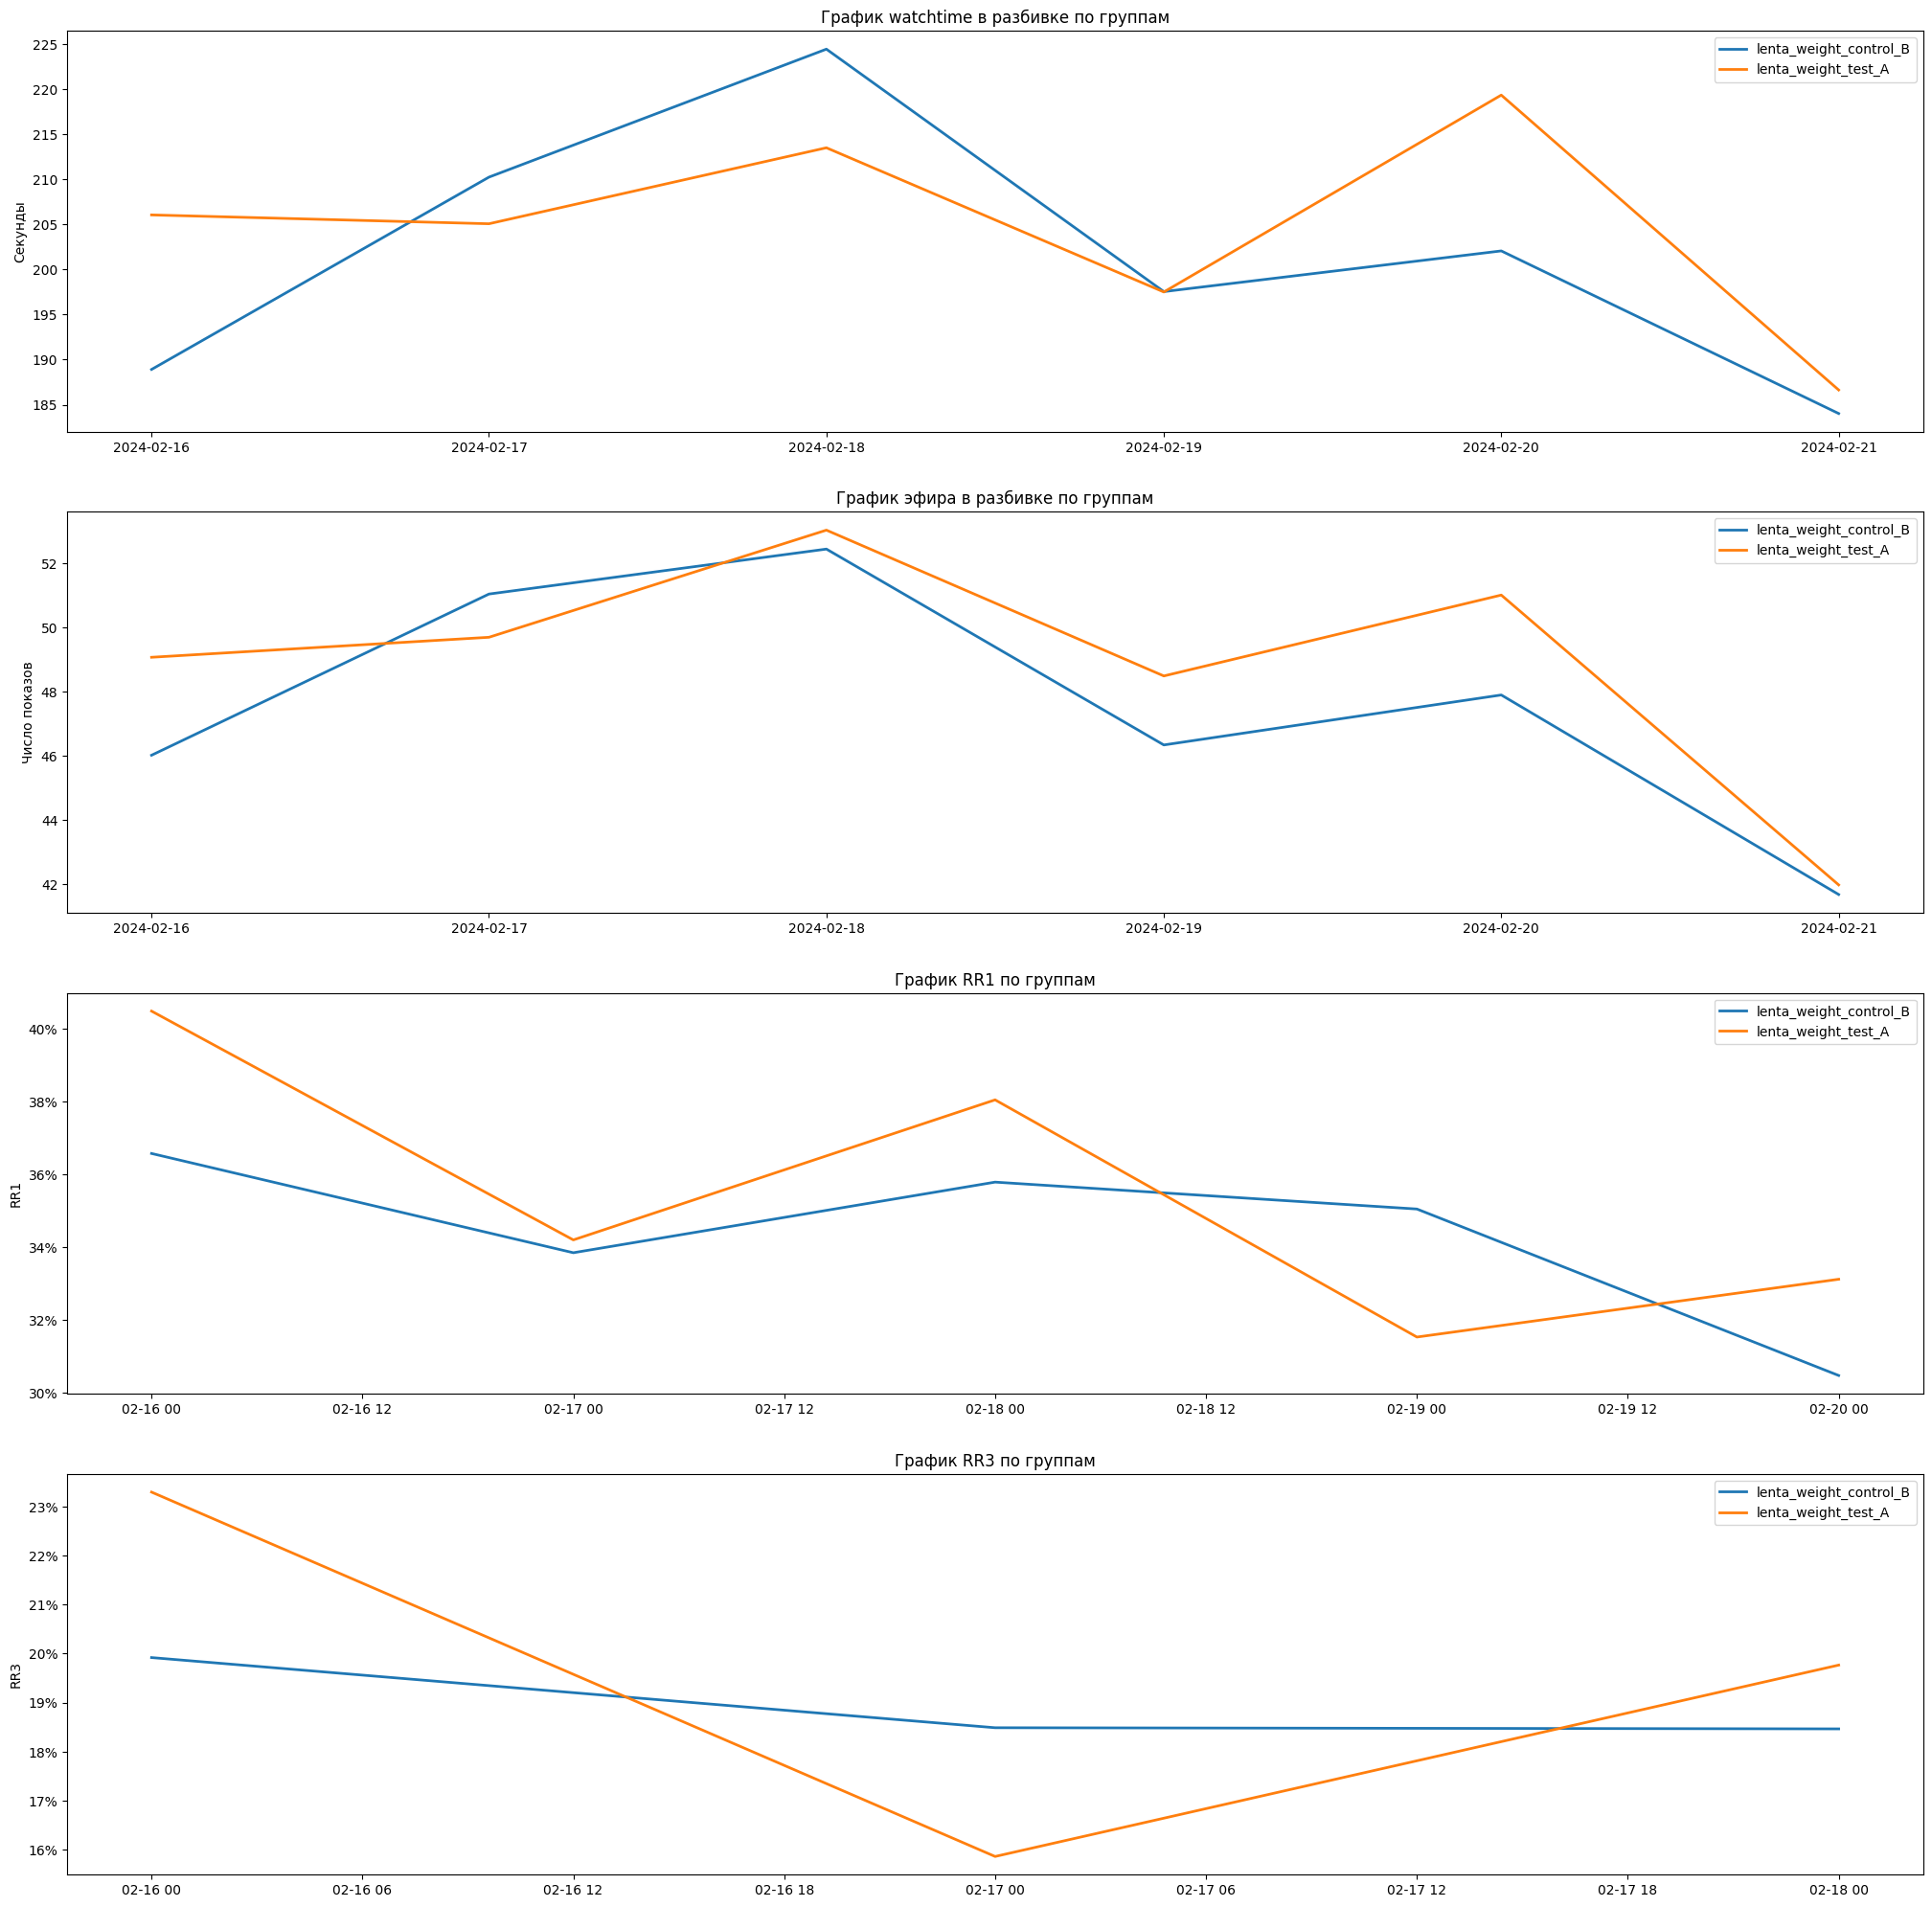

In [66]:
fix,axes = plt.subplots(4,1,figsize=(25,25))

# цикл по всем значениям experiment group
for i in df_register_agg['experiment_group'].unique():
    t = df_register_agg[df_register_agg['experiment_group']==i]

    axes[0].plot(t['date_msk'], t['watchtime'], label=i,linewidth=2)
    axes[1].plot(t['date_msk'], t['broadcast'], label=i,linewidth=2)
    
for i in df_register_first_date_agg['experiment_group'].unique():
    t1 = df_register_first_date_agg[df_register_first_date_agg['experiment_group']==i]
    axes[2].plot(t1['first_date_in_app'], t1['conv'], label=i,linewidth=2)
    

for i in df_register_third_date_agg['experiment_group'].unique():
    t3 = df_register_third_date_agg[df_register_third_date_agg['experiment_group']==i]
    axes[3].plot(t3['first_date_in_app'], t3['conv'], label=i,linewidth=2)
    


# Увеличиваем расстояние между графиками
plt.subplots_adjust(hspace=0.2)    

axes[0].set_title('График watchtime в разбивке по группам')
axes[0].legend()
axes[0].set_ylabel('Секунды')


axes[1].set_title('График эфира в разбивке по группам')
axes[1].legend()
axes[1].set_ylabel('Число показов')

axes[2].set_title('График RR1 по группам')
axes[2].legend()
axes[2].set_ylabel('RR1')
axes[2].yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1, decimals=0))

axes[3].set_title('График RR3 по группам')
axes[3].legend()
axes[3].set_ylabel('RR3')
axes[3].yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1, decimals=0))

plt.show()

## Тест на независимость

In [67]:
# Функция для хи-квадра по определению независимости между выборками
def chi_independence(df, control, test_1, segment_name, part=None):
        '''H0: distributions are independent, H1: distributions are dependent '''
        for segment in segment_name:
                control1 = df[df['experiment_group'] == control][segment].value_counts()
                test1 = df[df['experiment_group'] == test_1][segment].value_counts()
                # test2 = df[df['experiment_group'] == test_2][segment].value_counts()
                # test3 = df[df['experiment_group'] == test_3][segment].value_counts()
                
                #concat = pd.concat([control1,test1,test2,test3], axis=1)
                #concat.columns = ['control_1','test_1','test_2','test_3']
                concat = pd.concat([control1,test1], axis=1)
                concat.columns = ['control','test_1']
                if part:
                    print(concat.iloc[:part])
                    stat, p_value, dof, expected = stats.chi2_contingency(concat.iloc[:part])
                else:
                    stat, p_value, dof, expected = stats.chi2_contingency(concat)

                if p_value <= 0.01:
                        print (f" {segment}- p-value: {p_value:.4f}, statistic: {stat:.4f}, dof: {dof}, dependent (reject H0)\n")
                else:
                        print (f" {segment} - p-value: {p_value:.4f}, statistic: {stat:.4f}, dof: {dof}, independent (fail to reject H0)\n")


In [68]:
chi_independence(df_register,
                  control_group,
                  test_group_1,
                  #test_group_2,
                  #test_group_3,
                 ["os_name","country_type","device_manufacturer","device_model","app_version_name","os_version"],
                 15
                )

         control  test_1
os_name                 
1          20836   21195
0           2686    2682
 os_name - p-value: 0.5312, statistic: 0.3922, dof: 1, independent (fail to reject H0)

              control  test_1
country_type                 
Россия          20240   20650
СНГ              2487    2426
Остальные         625     589
 country_type - p-value: 0.1457, statistic: 3.8524, dof: 2, independent (fail to reject H0)

                      control  test_1
device_manufacturer                  
Redmi                  4544.0  4710.0
Samsung                3935.0  3939.0
Apple                  2635.0  2621.0
Realme                 2016.0  2115.0
Huawei                 1922.0  1832.0
Tecno                  1390.0  1498.0
Xiaomi                 1082.0  1146.0
Infinix                1040.0  1056.0
POCO                    706.0   789.0
Honor                   634.0   594.0
Oppo                    520.0   476.0
Vivo                    473.0   404.0
TECNO MOBILE LIMITED    276.0   265.0

## Тест на SRM (тест на однородность)

In [69]:
def chi_homogeneity(df, control, test_1, segment_name,number_of_groups, part=None):
    '''H0: distributions are homogeneous, H1: distributions are not homogeneous '''
    for segment in segment_name:
            control1 = df[df['experiment_group'] == control][segment].value_counts()
            test1 = df[df['experiment_group'] == test_1][segment].value_counts()
            # test2 = df[df['experiment_group'] == test_2][segment].value_counts()
            # test3 = df[df['experiment_group'] == test_3][segment].value_counts()
            concat = pd.concat([control1,test1], axis=1)
            concat.columns = ['control_1','test_1']
            concat['expected']=concat.sum(axis=1).apply(lambda x: math.ceil(x / number_of_groups))
            print(concat.iloc[:part])
            for i in concat.columns[:-1]:
                    # рассчитываем статистику
                    k = len(concat[i].iloc[:part])                                                                                             # число степеней свободы 
                    statistic = (((concat[i].iloc[:part] - concat['expected'].iloc[:part])**2)/concat['expected'].iloc[:part]).sum()           # КСП
                    # рассчитываем p-value 
                    p_value = 1 - stats.chi2.cdf(statistic, k - 1)                                                                             # вероятность получить значение выше или равное статистике
                    if p_value <= 0.01:
                            print (f" {segment}- p-value: {p_value:.4f}, statistic: {statistic:.4f}, dof: {k-1}, homogenes (reject H0)\n")
                    else:
                            print (f" {segment} - p-value: {p_value:.4f}, statistic: {statistic:.4f}, dof: {k-1}, not homogenes (fail to reject H0)\n")


In [70]:
chi_homogeneity(df_register,
                  control_group,
                  test_group_1,
                  # test_group_2,
                  # test_group_3,
                  ["os_name","country_type","device_manufacturer","device_model","app_version_name","os_version"],
                 num_of_bucket, # Количество групп в тесте 
                 15)

         control_1  test_1  expected
os_name                             
1            20836   21195     21016
0             2686    2682      2684
 os_name - p-value: 0.2141, statistic: 1.5432, dof: 1, not homogenes (fail to reject H0)

 os_name - p-value: 0.2167, statistic: 1.5261, dof: 1, not homogenes (fail to reject H0)

              control_1  test_1  expected
country_type                             
Россия            20240   20650     20445
СНГ                2487    2426      2457
Остальные           625     589       607
 country_type - p-value: 0.2281, statistic: 2.9556, dof: 2, not homogenes (fail to reject H0)

 country_type - p-value: 0.2253, statistic: 2.9804, dof: 2, not homogenes (fail to reject H0)

                      control_1  test_1  expected
device_manufacturer                              
Redmi                    4544.0  4710.0      4627
Samsung                  3935.0  3939.0      3937
Apple                    2635.0  2621.0      2628
Realme                

## Распределения 

In [71]:
def plot_segments_distribution(df, segment_columns, test_factor):
    for i in segment_columns:
        aggregated_data = df.groupby(by = [test_factor,i])['device_id'].count().reset_index()
        sns.catplot(x = i, 
                    y = 'device_id', 
                    hue = test_factor, # сообщаем, что хотим, чтобы разные группы имели разный цвет
                    data = aggregated_data.sort_values(by='device_id', ascending=False).iloc[:40], 
                    kind = "bar", 
                    height = 4, # задаем размер графика 
                    aspect = 1.5) # задаем ширину столбца
        plt.xticks(rotation=100)

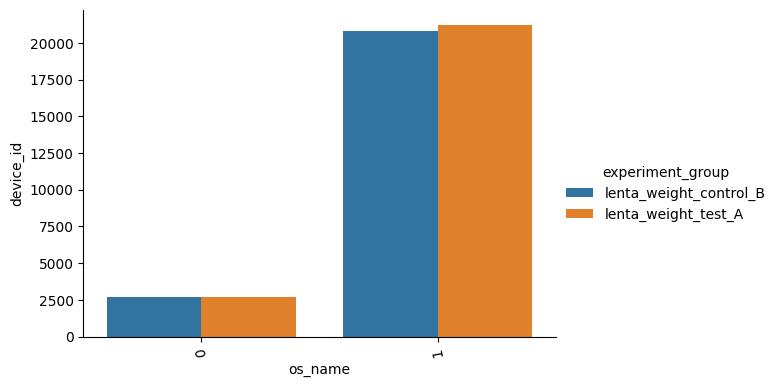

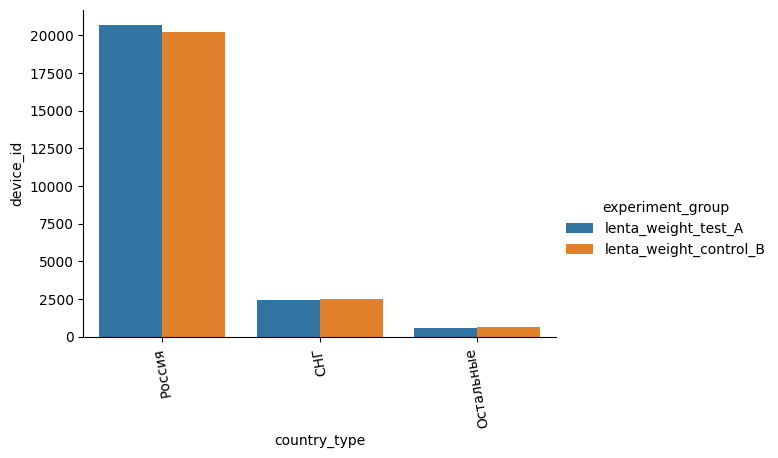

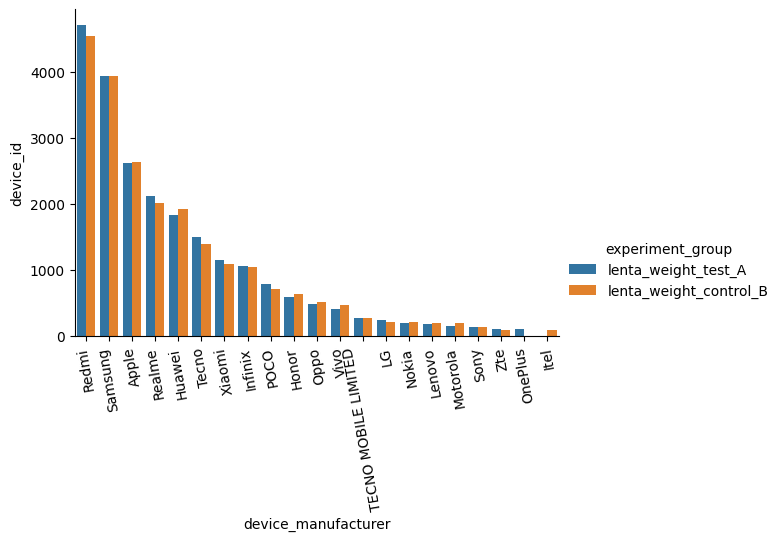

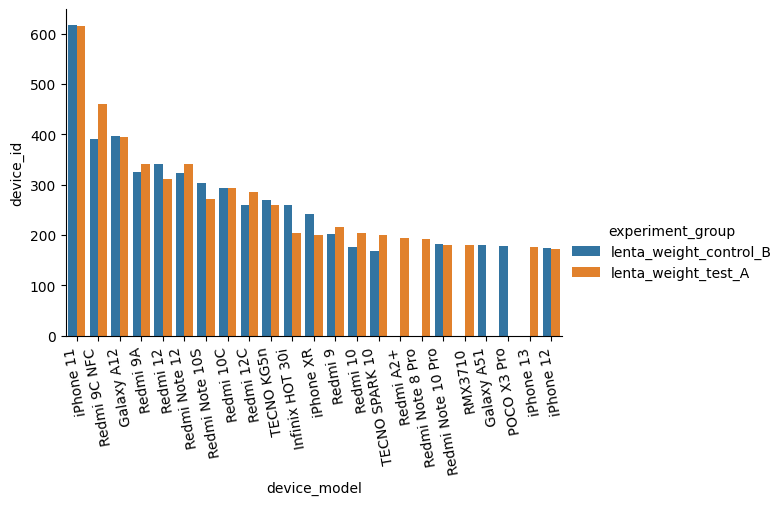

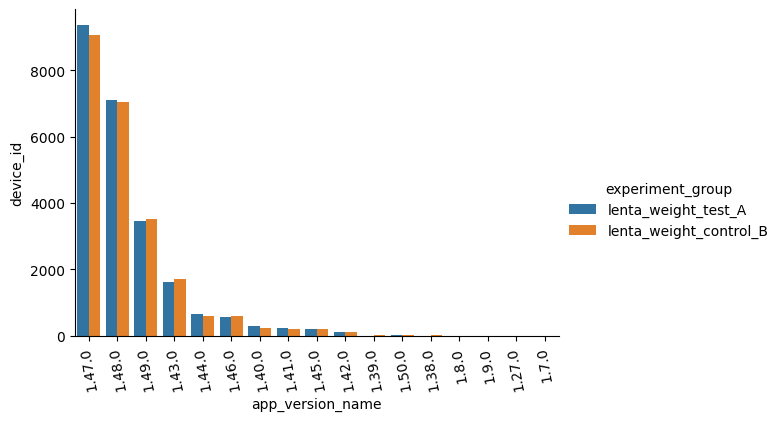

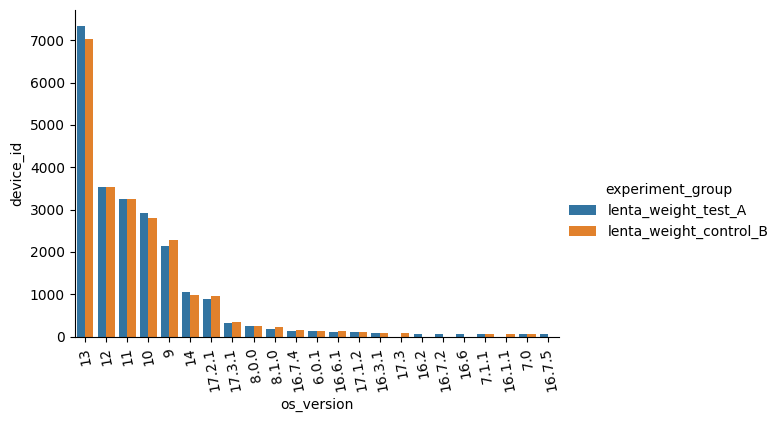

In [72]:
plot_segments_distribution(df_register, #датафрейм
                          ["os_name","country_type","device_manufacturer","device_model","app_version_name","os_version"],
                           "experiment_group",) #тест-фактор

## Добавим предэксперементальную группу

In [97]:
df_register_agg = df_register.groupby(['device_id','os_name','os_version','app_version_name','device_manufacturer','device_model','country_type','experiment_group','first_date_in_app','d_0','d_1','d_3']).agg({'watchtime':'sum','broadcast':'sum'}).reset_index()
df_register_agg

,device_id,os_name,os_version,app_version_name,device_manufacturer,device_model,country_type,experiment_group,first_date_in_app,d_0,d_1,d_3,watchtime,broadcast
0,000086cf-2d11-3ba9-88ba-cce4ad985569,1,10,1.47.0,Xiaomi,Mi A2 Lite,Россия,lenta_weight_test_A,2000-01-01,0.0,0.0,0.0,0.000,1
1,0000cdd1-a81e-3f58-a475-4199b2be404c,1,13,1.48.0,Tecno,TECNO SPARK 10 Pro,Россия,lenta_weight_control_B,2000-01-01,0.0,0.0,0.0,45.781,8
2,00033664-96d0-328e-b801-ea1ba706329e,1,11,1.47.0,Redmi,Redmi Note 10 Pro,Россия,lenta_weight_test_A,2024-02-20,1.0,0.0,0.0,782.339,212
3,0004a3f2-49ae-3c3a-8408-4eadcd4dbf4d,1,8.1.0,1.47.0,Raspberry,M1882,СНГ,lenta_weight_test_A,2024-02-19,1.0,0.0,0.0,60.526,6
4,0006e422-e769-3d15-a1a7-b8005c22d8d7,1,13,1.48.0,Redmi,Redmi Note 10 Pro,Россия,lenta_weight_control_B,2000-01-01,0.0,0.0,0.0,1.010,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30302,fff0585b-e830-3008-a245-90e3f95afee8,1,13,1.48.0,Samsung,Galaxy A51,Россия,lenta_weight_test_A,2000-01-01,0.0,0.0,0.0,93.529,44
30303,fff1d513-b045-3ae1-8cb4-f72240faf6bd,1,12,1.48.0,Samsung,Galaxy A12,Россия,lenta_weight_test_A,2000-01-01,0.0,0.0,0.0,339.288,50
30304,fffb6837-9ae5-36f5-aa6b-dd6819fd4276,1,13,1.48.0,Samsung,Galaxy S20 FE,Россия,lenta_weight_control_B,2000-01-01,0.0,0.0,0.0,0.681,4
30305,fffc245f-c5e4-3e6c-bf16-2be4b3fc9e43,1,12,1.40.0,Samsung,Galaxy A31,Россия,lenta_weight_control_B,2000-01-01,0.0,0.0,0.0,144.131,29


In [100]:
df_register_agg['watchtime'].var()

1069646.018778388

In [101]:
print(df_register_agg['device_id'].count())
print(df_register_agg['device_id'].nunique())

30307
30307


In [98]:
df_register_pre_week = df_merge[(df_merge['profile_type'] == 'Зарег') & (df_merge['empty_user'] == 0) & (df_merge['bot_flag']==0) & (df_merge['date_msk']>=cuped_date) & (df_merge['date_msk']<start_date)]
df_register_agg_pre_week = df_register_pre_week.groupby(['device_id','os_name','os_version','app_version_name','device_manufacturer','device_model','country_type','experiment_group','first_date_in_app','d_0','d_1','d_3']).agg({'watchtime':'sum','broadcast':'sum'}).reset_index()

df_register_pre_week['date_msk'].nunique()

7

In [121]:
df_register_agg_merge = pd.merge(df_register_agg,df_register_agg_pre_week[['device_id','watchtime']],on='device_id',how='left')
df_register_agg_merge.fillna(0,inplace=True)
df_register_agg_merge.rename(columns = {'watchtime_x':'watchtime_experiment','watchtime_y':'watchtime_pre_experiment'},inplace=True)


df_register_agg_merge['new_type'] = np.where(df_register_agg_merge['first_date_in_app']=='2000-01-01','Удержанные','Новые')
df_register_agg_merge

,device_id,os_name,os_version,app_version_name,device_manufacturer,device_model,country_type,experiment_group,first_date_in_app,d_0,d_1,d_3,watchtime_experiment,broadcast,watchtime_pre_experiment,new_type
0,000086cf-2d11-3ba9-88ba-cce4ad985569,1,10,1.47.0,Xiaomi,Mi A2 Lite,Россия,lenta_weight_test_A,2000-01-01,0.0,0.0,0.0,0.000,1,1159.391,Удержанные
1,0000cdd1-a81e-3f58-a475-4199b2be404c,1,13,1.48.0,Tecno,TECNO SPARK 10 Pro,Россия,lenta_weight_control_B,2000-01-01,0.0,0.0,0.0,45.781,8,507.696,Удержанные
2,00033664-96d0-328e-b801-ea1ba706329e,1,11,1.47.0,Redmi,Redmi Note 10 Pro,Россия,lenta_weight_test_A,2024-02-20,1.0,0.0,0.0,782.339,212,0.000,Новые
3,0004a3f2-49ae-3c3a-8408-4eadcd4dbf4d,1,8.1.0,1.47.0,Raspberry,M1882,СНГ,lenta_weight_test_A,2024-02-19,1.0,0.0,0.0,60.526,6,0.000,Новые
4,0006e422-e769-3d15-a1a7-b8005c22d8d7,1,13,1.48.0,Redmi,Redmi Note 10 Pro,Россия,lenta_weight_control_B,2000-01-01,0.0,0.0,0.0,1.010,3,3.964,Удержанные
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30302,fff0585b-e830-3008-a245-90e3f95afee8,1,13,1.48.0,Samsung,Galaxy A51,Россия,lenta_weight_test_A,2000-01-01,0.0,0.0,0.0,93.529,44,0.000,Удержанные
30303,fff1d513-b045-3ae1-8cb4-f72240faf6bd,1,12,1.48.0,Samsung,Galaxy A12,Россия,lenta_weight_test_A,2000-01-01,0.0,0.0,0.0,339.288,50,0.000,Удержанные
30304,fffb6837-9ae5-36f5-aa6b-dd6819fd4276,1,13,1.48.0,Samsung,Galaxy S20 FE,Россия,lenta_weight_control_B,2000-01-01,0.0,0.0,0.0,0.681,4,0.686,Удержанные
30305,fffc245f-c5e4-3e6c-bf16-2be4b3fc9e43,1,12,1.40.0,Samsung,Galaxy A31,Россия,lenta_weight_control_B,2000-01-01,0.0,0.0,0.0,144.131,29,0.000,Удержанные


## Квантильный анализ

In [122]:
quantiles=[1,2,3,4,5,6,7,8,9,10,25,50,75,80,85,90,91,92,93,94,95,96,97,98,99]
columns = ['watchtime_experiment','broadcast']


# пустой df для хранения результатов
quantiles_data = pd.DataFrame(index=quantiles, columns=columns)

for i in columns:
    data = df_register_agg_merge[i].dropna()
    quantile_values = np.percentile(data, quantiles)
    quantiles_data[i] = quantile_values

quantiles_data

,watchtime_experiment,broadcast
1,0.00000,1.0
2,0.00000,1.0
3,0.00000,1.0
4,0.00000,1.0
5,0.00000,1.0
6,0.00000,1.0
7,0.00000,1.0
8,0.00000,1.0
9,0.40100,1.0
10,0.80100,1.0


In [123]:
# Убираем 95 квантиль 
df_register_agg_wo_outlier = df_register_agg_merge[(df_register_agg_merge['watchtime_experiment']<np.percentile(df_register_agg_merge['watchtime_experiment'],95))]


# df_svr_merge_agg_wo_outlier_start = df_svr_merge_agg_start[(df_svr_merge_agg_start['watchtime']<np.percentile(df_svr_merge_agg_start['watchtime'],95))]
# df_svr_merge_agg_wo_outlier_stairs = df_svr_merge_agg_stairs[(df_svr_merge_agg_stairs['watchtime']<np.percentile(df_svr_merge_agg_stairs['watchtime'],95))]
# df_svr_merge_agg_wo_outlier_actual = df_svr_merge_agg_actual[(df_svr_merge_agg_actual['watchtime']<np.percentile(df_svr_merge_agg_actual['watchtime'],95))]

In [124]:
df_register_agg_wo_outlier['watchtime_experiment'].var()

68478.772055283

In [125]:
grouped_df = df_register_agg_wo_outlier.groupby('experiment_group').agg({'device_id':'count'})
total_count = grouped_df['device_id'].sum()
grouped_df.loc['Total'] = [total_count]
grouped_df

,device_id
experiment_group,
lenta_weight_control_B,14286
lenta_weight_test_A,14505
Total,28791


In [126]:
df_register_agg_merge.groupby('experiment_group')['watchtime_experiment'].mean()

experiment_group
lenta_weight_control_B    314.472838
lenta_weight_test_A       319.519505
Name: watchtime_experiment, dtype: float64

In [127]:
df_register_agg_wo_outlier.groupby('experiment_group')['watchtime_experiment'].mean()

experiment_group
lenta_weight_control_B    161.496610
lenta_weight_test_A       161.547401
Name: watchtime_experiment, dtype: float64

## Деление на группы эксперимента

In [128]:
control = df_register_agg_wo_outlier[df_register_agg_wo_outlier['experiment_group']==control_group]
test_1 = df_register_agg_wo_outlier[df_register_agg_wo_outlier['experiment_group']==test_group_1]

In [136]:
control[control['new_type']=='Удержанные']

,device_id,os_name,os_version,app_version_name,device_manufacturer,device_model,country_type,experiment_group,first_date_in_app,d_0,d_1,d_3,watchtime_experiment,broadcast,watchtime_pre_experiment,new_type
1,0000cdd1-a81e-3f58-a475-4199b2be404c,1,13,1.48.0,Tecno,TECNO SPARK 10 Pro,Россия,lenta_weight_control_B,2000-01-01,0.0,0.0,0.0,45.781,8,507.696,Удержанные
4,0006e422-e769-3d15-a1a7-b8005c22d8d7,1,13,1.48.0,Redmi,Redmi Note 10 Pro,Россия,lenta_weight_control_B,2000-01-01,0.0,0.0,0.0,1.010,3,3.964,Удержанные
5,000a64fe-3d63-36c5-bc6f-88ea18273558,1,13,1.43.0,Redmi,Redmi Note 12,Россия,lenta_weight_control_B,2000-01-01,0.0,0.0,0.0,479.374,90,0.000,Удержанные
7,000ccd6a-aaa2-3413-8117-0c94acafb03d,1,11,1.47.0,Itel,Vision 3,Россия,lenta_weight_control_B,2000-01-01,0.0,0.0,0.0,0.000,1,0.000,Удержанные
8,001f1f2a-9c47-4d75-943e-b83efbc55d02,0,17.2.1,1.48.0,Apple,iPhone XS,Россия,lenta_weight_control_B,2000-01-01,0.0,0.0,0.0,143.200,32,81.256,Удержанные
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30293,ffe5f78e-24b2-3801-9b7c-484dacd177a0,1,13,1.46.0,Realme,realme C25s,Россия,lenta_weight_control_B,2000-01-01,0.0,0.0,0.0,1.727,1,0.000,Удержанные
30294,ffe9c865-639d-3b6f-8f59-7cd1c534bb83,1,10,1.43.0,Huawei,DNN-LX9,Россия,lenta_weight_control_B,2000-01-01,0.0,0.0,0.0,9.373,5,0.000,Удержанные
30301,ffef0bd7-b21e-4908-ad58-c71934ed5877,0,16.7.4,1.49.0,Apple,iPhone X,Россия,lenta_weight_control_B,2000-01-01,0.0,0.0,0.0,0.000,4,0.000,Удержанные
30304,fffb6837-9ae5-36f5-aa6b-dd6819fd4276,1,13,1.48.0,Samsung,Galaxy S20 FE,Россия,lenta_weight_control_B,2000-01-01,0.0,0.0,0.0,0.681,4,0.686,Удержанные


## Постстратификация + CUPED

In [130]:
def calculate_theta(y_control, y_pilot, x_control, x_pilot):
    """Вычисляем Theta по данным двух групп """
    y = np.hstack([y_control, y_pilot])
    x = np.hstack([x_control, x_pilot])
    covariance = np.cov(x, y)[0, 1]
    variance = x.var()
    theta = covariance / variance
    return theta 

In [139]:
theta = calculate_theta (
                        control[control['new_type']=='Удержанные']['watchtime_experiment'], test_1[test_1['new_type']=='Удержанные']['watchtime_experiment'],
                        control[control['new_type']=='Удержанные']['watchtime_pre_experiment'], test_1[test_1['new_type']=='Удержанные']['watchtime_pre_experiment']
                        )



print(f'theta = {theta}')

theta = 0.10330728413105779


In [159]:
def calculate_strat_var(df, weights, covariate):
    """Вычисляет стратифицированную дисперсию."""
    strat_vars = df.groupby('device_model')[covariate].var()
    df_vars_weights = pd.merge(
        strat_vars,
        pd.Series(weights, name='weight'),
        how='inner',
        left_index=True,
        right_index=True
    )
    # если в данных df не было каких-то страт, то часть weights затрётся и сумма весов будет меньше 1
    df_vars_weights['weight'] = df_vars_weights['weight'] / df_vars_weights['weight'].sum()
    var_strat = (df_vars_weights['weight'] * df_vars_weights[covariate]).sum()
    return var_strat

In [160]:
def calculate_stratified_mean(df, weights, covariate):
    """Вычисляет стратифицированное среднее.

    df - датафрейм с целевой метрикой и данными для стратификации
    weights - словарь - {название страты: вес страты}

    return: float, mean_strat
    """
    strat_mean = df.groupby('device_model')[covariate].mean()
    df_means_weights = pd.merge(
        strat_mean,
        pd.Series(weights, name='weight'),
        how='inner',
        left_index=True,
        right_index=True
    )
    # если в данных df не было каких-то страт, то часть weights затрётся и сумма весов будет меньше 1
    df_means_weights['weight'] = df_means_weights['weight'] / df_means_weights['weight'].sum()
    mean_strat = (df_means_weights['weight'] * df_means_weights[covariate]).sum()
    return mean_strat

In [171]:
def check_stratified_cuped_test(df_control, df_pilot, weights,covariate):
    """Проверяет гипотезу о равенстве средних для стратифицированного среднего.
    
    return - pvalue.
    """
    theta = calculate_theta(
    df_control[df_control['new_type']=='Удержанные']['watchtime_experiment'], df_pilot[df_pilot['new_type']=='Удержанные']['watchtime_experiment'],
    df_control[df_control['new_type']=='Удержанные']['watchtime_pre_experiment'], df_pilot[df_pilot['new_type']=='Удержанные']['watchtime_pre_experiment']
    )
     

    df_pilot['watchtime_cuped'] = df_pilot['watchtime_experiment'] - theta * df_pilot['watchtime_pre_experiment']
    df_control['watchtime_cuped'] = df_control['watchtime_experiment'] - theta * df_control['watchtime_pre_experiment']
    
    mean_strat_control = calculate_stratified_mean(df_control, weights,covariate)
    mean_strat_pilot = calculate_stratified_mean(df_pilot, weights,covariate)
    var_strat_control = calculate_strat_var(df_control, weights,covariate)
    var_strat_pilot = calculate_strat_var(df_pilot, weights,covariate)
    delta_mean_strat = mean_strat_pilot - mean_strat_control
    std_mean_strat = (var_strat_pilot / len(df_pilot) + var_strat_control / len(df_control)) ** 0.5
    t = delta_mean_strat / std_mean_strat
    pvalue = (1 - stats.norm.cdf(np.abs(t))) * 2
    return pvalue,var_strat_control,mean_strat_pilot

In [172]:
weights = df_register_agg['device_model'].value_counts(normalize=True).to_dict()

print(calculate_strat_var(test_1,weights,'watchtime_experiment'))
print(test_1['watchtime_experiment'].var())


64257.485748392
68209.44759426608


In [173]:
weights = df_register_agg['device_model'].value_counts(normalize=True).to_dict()

theta = calculate_theta(
    control[control['new_type']=='Удержанные']['watchtime_experiment'], test_1[test_1['new_type']=='Удержанные']['watchtime_experiment'],
    control[control['new_type']=='Удержанные']['watchtime_pre_experiment'], test_1[test_1['new_type']=='Удержанные']['watchtime_pre_experiment']
    )
     

test_1['watchtime_cuped'] = test_1['watchtime_experiment'] - theta * test_1['watchtime_pre_experiment']
control['watchtime_cuped'] = control['watchtime_experiment'] - theta * control['watchtime_pre_experiment']

print(calculate_strat_var(test_1,weights,'watchtime_cuped'))
print(test_1['watchtime_experiment'].var())


62249.5644281941
68209.44759426608


## Retention 1-го дня

In [218]:
# Удаляем пустые строки, чтобы оставить новичков и посмотреть их retention 
df_retention_day_1 = df_register_agg_wo_outlier[(df_register_agg_wo_outlier['first_date_in_app']!='2000-01-01') & (df_register_agg_wo_outlier['first_date_in_app']<=day_retention_1_day)]
print("Количество дней для расчета retention 1-го дня:", df_retention_day_1['first_date_in_app'].nunique())


# Разбили на группы и проверяем сплитование 
control_retention_1_day = df_retention_day_1[df_retention_day_1['experiment_group'] == control_group]
test_1_retention_1_day = df_retention_day_1[df_retention_day_1['experiment_group'] == test_group_1]


# plot_segments_distribution(df_retention_day_1, #датафрейм
#                            ["os_name","country_type","device_manufacturer","device_model","app_version_name","os_version"],
#                            "experiment_group") #тест-фактор

Количество дней для расчета retention 1-го дня: 5


## Retention 3-го дня

In [219]:
# Удаляем пустые строки, чтобы оставить новичков и посмотреть их retention 
df_retention_3_day = df_register_agg_wo_outlier[(df_register_agg_wo_outlier['first_date_in_app']!='2000-01-01') & (df_register_agg_wo_outlier['first_date_in_app']<=day_retention_3_day)]
print("Количество дней для расчета retention 3-го дня:", df_retention_3_day['first_date_in_app'].nunique())

# Разбили на группы и проверяем сплитование 
control_retention_3_day = df_retention_3_day[df_retention_3_day['experiment_group']== control_group]
test_1_retention_3_day = df_retention_3_day[df_retention_3_day['experiment_group']== test_group_1]


Количество дней для расчета retention 3-го дня: 3


## Подсчет среднего и расчет критериев

In [220]:
weights = df_register_agg['device_model'].value_counts(normalize=True).to_dict()

broadcast_control = control['broadcast'].mean()
broadcast_test_1 = test_1['broadcast'].mean()
broadcast_ttest_control_to_test1 = ttest_ind(control['broadcast'],test_1['broadcast'],equal_var=False)[1]


watchtime_control = calculate_stratified_mean(control,weights,'watchtime_cuped')
watchtime_test_1 = calculate_stratified_mean(test_1,weights,'watchtime_cuped')
watchtime_ttest_control_to_test1 = check_stratified_cuped_test(control,test_1,weights,'watchtime_cuped')[0]




retention_1_day_control = control_retention_1_day['d_1'].mean() * 100
retention_1_day_test_1 = test_1_retention_1_day['d_1'].mean() * 100
retention_1_day_ttest_control_to_test1 = ttest_ind(control_retention_1_day['d_1'],test_1_retention_1_day['d_1'],equal_var=False)[1]



retention_3_day_control = control_retention_3_day['d_3'].mean() * 100
retention_3_day_test_1 = test_1_retention_3_day['d_3'].mean() * 100
retention_3_day_ttest_control_to_test1 = ttest_ind(control_retention_3_day['d_3'],test_1_retention_3_day['d_3'],equal_var=False)[1]



## Симмуляция Монте-Карло для контроля ошибок I и II рода

In [221]:
def mde_estimated_absolute (ttl_users,var,alpha,beta):
        t_alpha = stats.norm.ppf(1 - alpha/(num_of_bucket - 1)/ 2, loc=0, scale=1)
        t_beta = stats.norm.ppf(1 - beta, loc=0, scale=1)
        var = 2 * var
        MDE=(t_alpha+t_beta) * np.sqrt(var  / ttl_users)
        return MDE

In [222]:
math.ceil(df_register_agg_wo_outlier['device_id'].nunique())

28791

In [223]:
ttl_users = math.ceil(df_register_agg_wo_outlier['device_id'].nunique()/num_of_bucket)
var = test_1['watchtime_experiment'].var()
mean = test_1['watchtime_experiment'].mean()
mde_absolute=mde_estimated_absolute(ttl_users,var,0.05,0.2)
MDE = mde_absolute / mean

print('MDE абсолютный:',round(mde_absolute,4))
print('MDE относительный:',round(MDE,4))
print('Средний watchtime за неделю:',round(mean,4))
print('Дисперсия',round(var,4)) 
print('Число пользователей',math.ceil(ttl_users))

MDE абсолютный: 8.6242
MDE относительный: 0.0534
Средний watchtime за неделю: 161.5474
Дисперсия 68209.4476
Число пользователей 14396


100%|██████████| 10000/10000 [00:51<00:00, 194.30it/s]


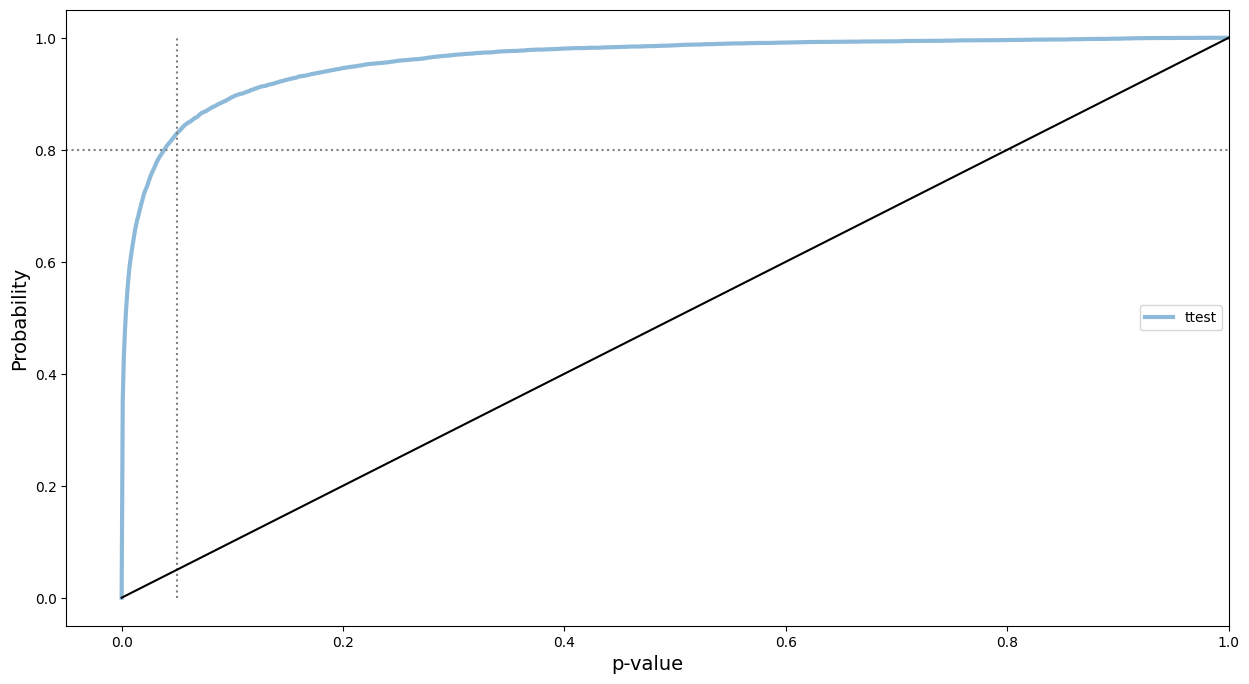

In [191]:
ttl_users = math.ceil(df_register_agg_wo_outlier['device_id'].nunique()/num_of_bucket)
effect = 9
pvalues_ttest = []
mean = []
for i in tqdm(range(10000)):
    
        df_control_wo_outlier = df_register_agg_wo_outlier.sample(n = ttl_users,replace=True)
        df_pilot_wo_outlier = df_register_agg_wo_outlier.sample(n = ttl_users,replace=True)
        df_pilot_wo_outlier['watchtime_experiment'] += effect
        means = df_pilot_wo_outlier['watchtime_experiment'].mean()
        pvalue = stats.ttest_ind(df_control_wo_outlier['watchtime_experiment'], df_pilot_wo_outlier['watchtime_experiment'])[1]
        
        pvalues_ttest.append(pvalue)
        mean.append(means)
        
list_pvalues = [pvalues_ttest]
list_titles = ['ttest']
plt.figure(figsize=(15,8))

X = np.linspace(0, 1, 1000)
for pvalues, title in zip(reversed(list_pvalues), reversed(list_titles)):
    pvalues = np.array(pvalues)
    Y = [np.mean(pvalues < x) for x in X]
    plt.plot(X, Y, alpha=0.5, linewidth=3, label=title)
plt.xlabel('pvalue')
x_values = [0.05/(num_of_bucket - 1)]
plt.vlines(x_values, ymin=0, ymax=1, linestyles='dotted', colors='gray')
plt.axhline(y=0.8, color='gray', linestyle='dotted')
plt.xlim([-0.05, 1])
plt.xlabel('p-value', size=14)
plt.ylabel('Probability', size=14)
plt.plot([0, 1], [0, 1], 'k')
plt.legend(loc=5)
plt.show()        

In [224]:
final_table_register = []

row1 = [watchtime_control, watchtime_test_1, watchtime_ttest_control_to_test1]
row2 = [broadcast_control, broadcast_test_1, broadcast_ttest_control_to_test1]

# row3 = [watchtime_control_1_start, watchtime_test_1_start, watchtime_ttest_control_to_test1_start]
# row4 = [watchtime_control_1_stairs, watchtime_test_1_stairs, watchtime_ttest_control_to_test1_stairs]
# row5 = [watchtime_control_1_actual, watchtime_test_1_actual, watchtime_ttest_control_to_test1_actual]

row6 = [retention_1_day_control, retention_1_day_test_1, retention_1_day_ttest_control_to_test1] 
row7 = [retention_3_day_control, retention_3_day_test_1, retention_3_day_ttest_control_to_test1]

# row8 = [register_control_, register_test_1, register_test_2, register_test_3, register_ttest_control_to_test1, register_ttest_control_to_test2, register_ttest_control_to_test3]
# row9 = [watchtime_start_select_control_1, watchtime_start_test_1, watchtime_start_test_2, watchtime_start_test_3, watchtime_start_ttest_control_to_test1, watchtime_start_ttest_control_to_test2, watchtime_start_ttest_control_to_test3]


final_table_register.append(row1)
final_table_register.append(row2)
# final_table_register.append(row3)
# final_table_register.append(row4)
# final_table_register.append(row5)
final_table_register.append(row6)
final_table_register.append(row7)
# final_table_register.append(row8)
# final_table_register.append(row9)





final_table_register = pd.DataFrame(final_table_register, index=['Watchtime за 7 дней, сек','Эфир за 7 дней', 'Retention 1-го дня, %','Retention 3-го дня, %'], columns=['контроль', 'тест 1', 'тест 1 к контролю'])

final_table_register['тест 1 к контролю']=np.where(final_table_register['тест 1 к контролю'].isna(), 0, np.where(final_table_register['тест 1 к контролю']<0.05/num_of_bucket, round((final_table_register['тест 1'] / final_table_register['контроль'] - 1) * 100,2), 'Нет различия'))
# final_table_register['тест 2 к контролю']=np.where(final_table_register['тест 2 к контролю'].isna(), 0, np.where(final_table_register['тест 2 к контролю']<0.05/num_of_bucket, round((final_table_register['тест 2'] / final_table_register['контроль'] - 1) * 100,2), 'Нет различия'))
# final_table_register['тест 3 к контролю']=np.where(final_table_register['тест 3 к контролю'].isna(), 0, np.where(final_table_register['тест 3 к контролю']<0.05/num_of_bucket, round((final_table_register['тест 3'] / final_table_register['контроль'] - 1) * 100,2), 'Нет различия'))
final_table_register

,контроль,тест 1,тест 1 к контролю
"Watchtime за 7 дней, сек",149.846816,148.565763,Нет различия
Эфир за 7 дней,42.244715,41.372216,Нет различия
"Retention 1-го дня, %",16.908016,17.551593,Нет различия
"Retention 3-го дня, %",6.990596,7.151703,Нет различия


In [226]:
final_table_register['тест 1 к контролю']= np.where(final_table_register['тест 1 к контролю']=='Нет различия',final_table_register['тест 1 к контролю'], np.where(final_table_register['тест 1 к контролю'].str.contains('-'),final_table_register['тест 1 к контролю'] + '%','+' + final_table_register['тест 1 к контролю'] + '%'))


In [227]:
final_table_register[['контроль', 'тест 1','тест 1 к контролю']].style.applymap(color_cell, subset=['тест 1 к контролю'])

,контроль,тест 1,тест 1 к контролю
"Watchtime за 7 дней, сек",149.846816,148.565763,Нет различия
Эфир за 7 дней,42.244715,41.372216,Нет различия
"Retention 1-го дня, %",16.908016,17.551593,Нет различия
"Retention 3-го дня, %",6.990596,7.151703,Нет различия
